In [1]:
import os
from PIL import Image
import timeit
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.io as io
import torch.optim as optim
import matplotlib.pyplot as plt
import random

# 1) Classification using CNN

### 1.1

In [2]:
def load_mnist_data(dataset_path):
    splits = ['train', 'val', 'test']
    data = {}
    
    for split in splits:
        images = []
        labels = []
        split_path = os.path.join(dataset_path, split)
        print(split_path)
        for label_folder in os.listdir(split_path):
            label_folder_path = os.path.join(split_path, label_folder)

            if not os.path.isdir(label_folder_path):
                continue
            if label_folder == '0':
                label = 0
            else:
                label = len(label_folder)

            for img_file in os.listdir(label_folder_path):
                img_path = os.path.join(label_folder_path, img_file)
                if not os.path.isfile(img_path):
                    continue
                
                img = Image.open(img_path).convert('L')
                images.append(img)
                labels.append(label)

        data[split] = (images, labels)

    return data['train'], data['val'], data['test']

# train_data, val_data, test_data = load_mnist_data('/kaggle/input/double-mnist/double_mnist/')
# train_data, val_data, test_data = load_mnist_data('/Users/shravangadbail/Desktop/College/3.1/SMAI/Assignments/smai-m24-assignments-ShravanGadbail/data/external/double_mnist')


In [3]:
# train_data, val_data, test_data = load_mnist_data('/kaggle/input/double-mnist2/double_mnist')
train_data, val_data, test_data = load_mnist_data('/double_mnist')

/kaggle/input/double-mnist2/double_mnist/train
/kaggle/input/double-mnist2/double_mnist/val
/kaggle/input/double-mnist2/double_mnist/test


In [4]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image.clone().detach(), label

In [5]:
train_images, train_labels = train_data
val_images, val_labels = val_data
test_images, test_labels = test_data

transform = transforms.Compose([transforms.Grayscale(),transforms.ToTensor()])

train_df = MultiMNISTDataset(train_images, train_labels, transform=transform)
val_df = MultiMNISTDataset(val_images, val_labels, transform=transform)
test_df = MultiMNISTDataset(test_images, test_labels, transform=transform)

train = DataLoader(train_df, batch_size=32, shuffle=True)
val = DataLoader(val_df, batch_size=32, shuffle=False)
test = DataLoader(test_df, batch_size=32, shuffle=False)

### 2.2

In [47]:
class CNN(nn.Module):
    def __init__(self, size = (32,1,128,128), optimizer='Adam', activation='relu', pool_type='max', task='classification', stride=2, num_conv_layers=2, conv_kernel_size=3, pool_kernel_size=2,num_classes=4, dropout_rate=0.5):
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.to(device)
        super(CNN, self).__init__()
        self.task = task
        self.num_classes = num_classes
        self.num_conv_layers = num_conv_layers
        self.activation=activation
        self.optimizer = optimizer

        out_channels=16
        in_channels = 16
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(nn.Conv2d(in_channels=size[1], out_channels=out_channels, kernel_size=conv_kernel_size, padding=1,stride=stride))
        out_channels*=2
        for i in range(num_conv_layers-1):
            conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_kernel_size, padding=1,stride=stride)
            self.conv_layers.append(conv)
            in_channels = out_channels
            out_channels*=2

        if pool_type=='max':
            self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=stride)
        elif pool_type=='avg':
            self.pool = nn.AvgPool2d(kernel_size=pool_kernel_size, stride=stride)

        dummy_input = torch.zeros(1, size[1], size[2], size[3])
        flatsize = self.getSize(dummy_input)
#         print("Flatsize",flatsize)
        self.fc1 = nn.Linear(flatsize, 128)
        self.fc2 = nn.Linear(128, 64)

        self.dropout = nn.Dropout(dropout_rate)

        if task == 'classification':
            self.output = nn.Linear(64, num_classes)
        elif task == 'regression':
            self.output = nn.Linear(64, 1)

    def getSize(self,x):
        # print("Getsize start",x.size())
        for i in range(self.num_conv_layers):
            x = self.pool(self.conv_layers[i](x))
            # print(x.size())
        # print("Getsize end")
        return x.numel()

    def forward(self, x, maps = False):
        feature_maps = []
        activation_func = {
            'relu': F.relu,
            'sigmoid': F.sigmoid,
            'tanh': F.tanh,
            'leaky_relu': F.leaky_relu}.get(self.activation, F.relu)
        for i in range(self.num_conv_layers):
            x = self.pool(activation_func(self.conv_layers[i](x)))
            if maps:
                feature_maps.append(x.clone().detach())

        x = x.reshape(x.size(0),-1)

        x = self.fc1(x)
        x = activation_func(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = activation_func(x)
        x = self.dropout(x)

        x = self.output(x)
        if maps:
            return x,feature_maps
        return x

    def train_model(self, train_loader, val_loader, num_epochs=30, learning_rate=0.001,patience=3):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        # print(device)
        if self.optimizer=='Adam':
            optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        elif self.optimizer=='SGD':
            optimizer = optim.SGD(self.parameters(), lr=learning_rate)

        if self.task == 'classification':
            criterion = nn.CrossEntropyLoss()
        elif self.task == 'regression':
            criterion = nn.MSELoss()

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self.forward(images)

                if self.task == 'regression':
                    labels = labels.float()
                    predicted = torch.round(outputs).to(torch.int)

                elif self.task == 'classification':
                    _, predicted = torch.max(outputs.data, 1)

                outputs = outputs.squeeze()
                loss = criterion(outputs, labels)
                predicted = predicted.squeeze()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                loss.backward()
                optimizer.step()
        
                running_loss += loss.item()

            val_loss, val_hamming_accuracy = self.evaluate_model(val_loader)
            avg_loss = running_loss / len(train_loader)
            train_losses.append(avg_loss)
            val_losses.append(val_loss)

            accuracy = correct / total * 100
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping done")
                    break

        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss over Epochs")
        plt.show()

    def evaluate_model(self, val_loader):   
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval()

        # Create the criterion once at the beginning
        if self.task == 'classification':
            criterion = nn.CrossEntropyLoss()
        else:
            criterion = nn.MSELoss()

        loss_total = 0.0
        accurate_count = 0
        data_size = 0

        for batch_data, batch_labels in val_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            preds = self.forward(batch_data)
#             print("Batch lables",batch_labels.size())
            # Use criterion to calculate loss
            if self.task == 'regression':
                preds = preds.squeeze()
                preds = preds.float()


            loss = criterion(preds, batch_labels)
            loss_total += loss.item()
#             print("Preds",preds.size())
#             _, chosen_class = preds.max(1)
            if self.task == 'regression':
                chosen_class = torch.round(preds).to(int)
            elif self.task == 'classification':
                _, chosen_class = preds.max(1)
            
            accurate_count += (chosen_class == batch_labels).sum().item()
            data_size += batch_labels.size(0)

        mean_loss = loss_total / len(val_loader)

        val_accuracy = (accurate_count / data_size) * 100
        print(f"Validation Mean Loss: {mean_loss} | Accuracy: {val_accuracy}%")
        return mean_loss, val_accuracy

    def visualize_feature_maps(self, images, num_images=3):
        self.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        images = images.to(device)
        fig, axs = plt.subplots(num_images, self.num_conv_layers+1, figsize=(15, num_images * 3))
        for i in range(num_images):
            img = images[i].unsqueeze(0)
            _, feature_maps = self.forward(img, maps=True)
            
            # Chatgpt starts here
            original_image = img[0].cpu().detach().squeeze()
            axs[i, 0].imshow(original_image, cmap='gray')
            axs[i, 0].axis('off')
            axs[i, 0].set_title("Original Image")
            # ends here
        
            for j, fmap in enumerate(feature_maps):
                fmap = fmap[0].cpu().detach()
                axs[i, j+1].imshow(fmap[0], cmap='viridis')
                axs[i, j+1].axis('off')
                axs[i, j+1].set_title(f'Layer {j + 1}')
        
        plt.show()

In [ ]:
# model = CNN(task='classification', num_classes=10, dropout_rate=0.5)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [ ]:
# model.train_model(train, val, num_epochs=10, task='classification', learning_rate=0.001)

### 2.3

#### Key hyperparameters:
1.	Learning Rate
2.	Batch Size
3.	Number of Epochs
4.	Filter/Kernel Size
5.	Number of convolutional layers
6.	Stride
7.	Padding
8.	Activation Function
9.	Pooling Type
10.	Dropout Rate
11.	Optimizer

The possible values of hypermeters is listed below (in code)

In [7]:
# Learning Rate
learning_rates = [0.001, 0.01]
# Filter/Kernel Size
conv_kernel_sizes = [2]
pool_kernel_sizes = [2]
# Number of convolutional layers
num_conv_layers = [3, 2]
# Stride
strides = [2]
# Activation Function
activations = ['relu', 'leaky_relu']
# Pooling Type
# pooling_types = ['max', 'avg']
pooling_types = ['max']
# Dropout Rate
dropout_rates = [0.25, 0.5]
# Optimizer
optimizers = ['Adam','SGD']

## Hyperparameter tuning for classification

True
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.25; Optimizer: Adam
Validation Mean Loss: 0.34024687903992673 | Accuracy: 85.1%
Epoch [1/30], Loss: 0.8554, Accuracy: 63.83%
Validation Mean Loss: 0.24740257799783918 | Accuracy: 90.13333333333333%
Epoch [2/30], Loss: 0.3370, Accuracy: 85.55%
Validation Mean Loss: 0.22038454465330282 | Accuracy: 92.23333333333333%
Epoch [3/30], Loss: 0.2579, Accuracy: 89.77%
Validation Mean Loss: 0.21538238947656244 | Accuracy: 92.36666666666666%
Epoch [4/30], Loss: 0.2167, Accuracy: 91.49%
Validation Mean Loss: 0.18182498022438365 | Accuracy: 93.56666666666666%
Epoch [5/30], Loss: 0.1923, Accuracy: 92.75%
Validation Mean Loss: 0.18706252788035002 | Accuracy: 93.7%
Epoch [6/30], Loss: 0.1730, Accuracy: 93.58%
Validation Mean Loss: 0.18913687583296857 | Accuracy: 93.46666666666667%
Epoch [7/30], Loss: 0.1657, Accuracy: 93.92%
V

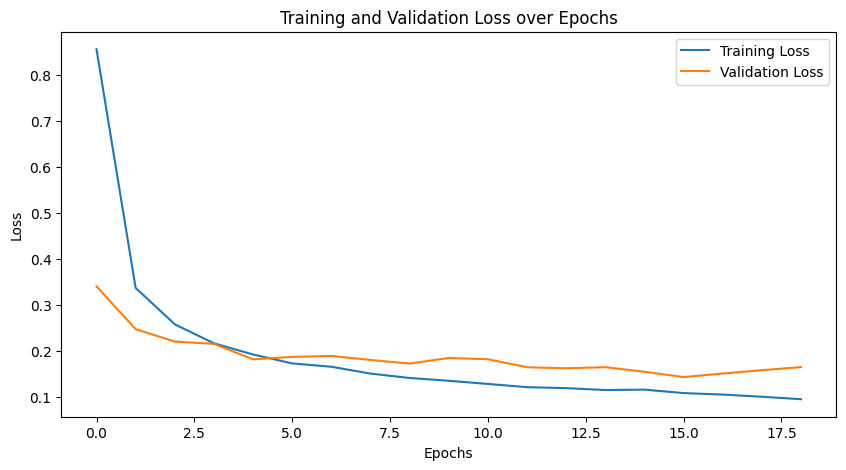

Validation Mean Loss: 0.1649184460817351 | Accuracy: 94.33333333333334%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.25; Optimizer: SGD
Validation Mean Loss: 2.199539316461441 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 2.2692, Accuracy: 14.63%
Validation Mean Loss: 2.076261573649467 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 2.1448, Accuracy: 50.79%
Validation Mean Loss: 1.9600258938809658 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 2.0300, Accuracy: 50.79%
Validation Mean Loss: 1.844255822770139 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.9182, Accuracy: 50.79%
Validation Mean Loss: 1.723785213967587 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.8056, Accuracy: 50.79%
Validation Mean Loss: 1.5981270049480683 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 1.6880, Accuracy: 50.79%
Validation Mean Loss: 1.4680788

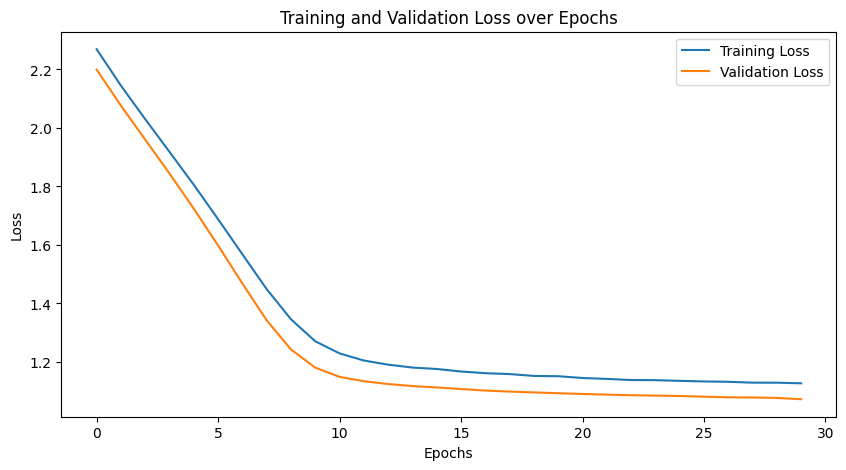

Validation Mean Loss: 1.0726125493962715 | Accuracy: 53.333333333333336%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.5; Optimizer: Adam
Validation Mean Loss: 0.35837154026995316 | Accuracy: 85.83333333333333%
Epoch [1/30], Loss: 0.8661, Accuracy: 62.38%
Validation Mean Loss: 0.28444704881056826 | Accuracy: 89.43333333333334%
Epoch [2/30], Loss: 0.3768, Accuracy: 83.67%
Validation Mean Loss: 0.2021210583600592 | Accuracy: 92.60000000000001%
Epoch [3/30], Loss: 0.2839, Accuracy: 88.09%
Validation Mean Loss: 0.20916686924372582 | Accuracy: 92.86666666666666%
Epoch [4/30], Loss: 0.2408, Accuracy: 90.78%
Validation Mean Loss: 0.20446681751413864 | Accuracy: 92.80000000000001%
Epoch [5/30], Loss: 0.2116, Accuracy: 92.09%
Validation Mean Loss: 0.1581650634910515 | Accuracy: 94.6%
Epoch [6/30], Loss: 0.1911, Accuracy: 92.98%
Validation Mean Loss: 0.17776951654516954

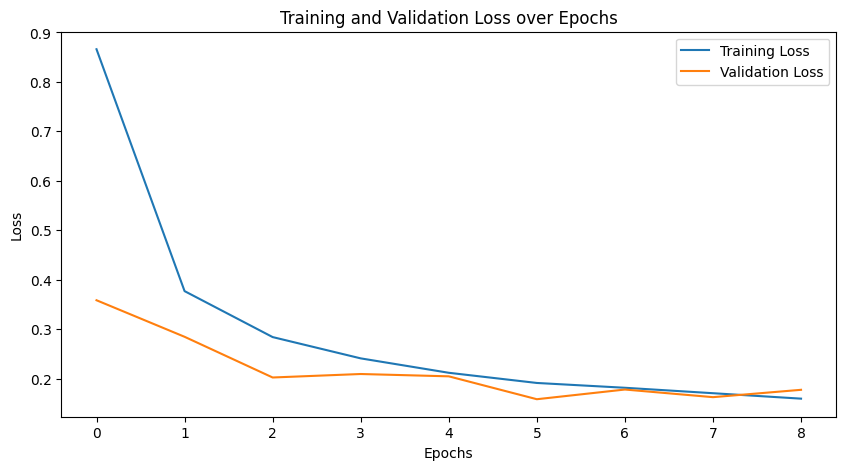

Validation Mean Loss: 0.1772035840363737 | Accuracy: 93.83333333333333%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.5; Optimizer: SGD
Validation Mean Loss: 2.11122080620299 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 2.1825, Accuracy: 40.32%
Validation Mean Loss: 1.977952353497769 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 2.0524, Accuracy: 50.78%
Validation Mean Loss: 1.847368154119938 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.9276, Accuracy: 50.79%
Validation Mean Loss: 1.7105772888406794 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.8026, Accuracy: 50.79%
Validation Mean Loss: 1.5605378442622246 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.6702, Accuracy: 50.79%
Validation Mean Loss: 1.4056254118046863 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 1.5339, Accuracy: 50.79%
Validation Mean Loss: 1.28175084

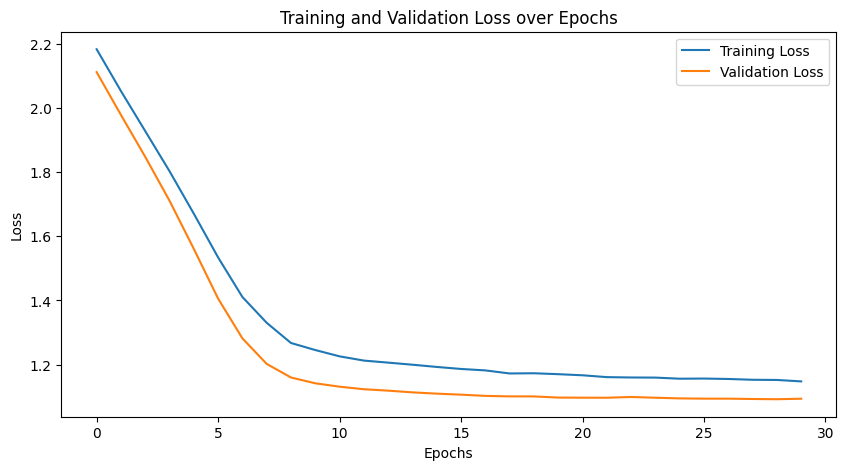

Validation Mean Loss: 1.0937409026825682 | Accuracy: 53.333333333333336%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.25; Optimizer: Adam
Validation Mean Loss: 0.2957029253085877 | Accuracy: 87.2%
Epoch [1/30], Loss: 0.7836, Accuracy: 65.83%
Validation Mean Loss: 0.23917730200163861 | Accuracy: 90.0%
Epoch [2/30], Loss: 0.2975, Accuracy: 87.71%
Validation Mean Loss: 0.23094657773865349 | Accuracy: 91.43333333333334%
Epoch [3/30], Loss: 0.2237, Accuracy: 91.09%
Validation Mean Loss: 0.1771649894641435 | Accuracy: 93.83333333333333%
Epoch [4/30], Loss: 0.2004, Accuracy: 92.30%
Validation Mean Loss: 0.21074843093098955 | Accuracy: 93.0%
Epoch [5/30], Loss: 0.1883, Accuracy: 92.90%
Validation Mean Loss: 0.18279796845695756 | Accuracy: 93.8%
Epoch [6/30], Loss: 0.1660, Accuracy: 93.94%
Validation Mean Loss: 0.19013547219529234 | Accuracy: 93.7%
Epoch [7/30],

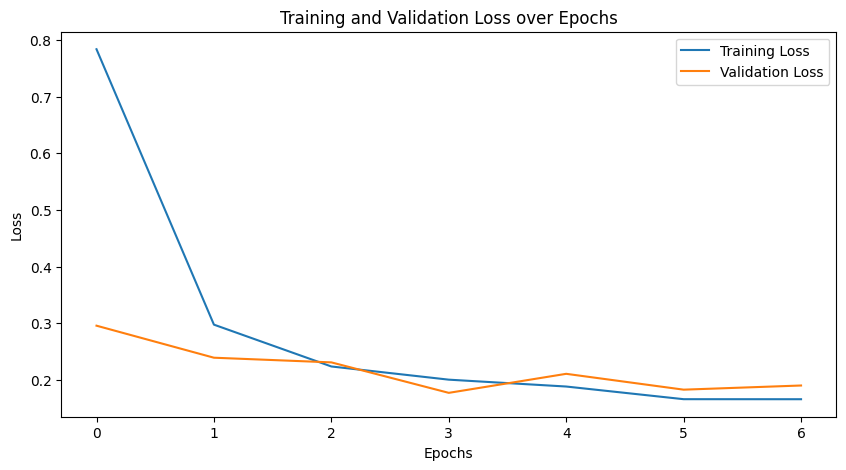

Validation Mean Loss: 0.19013547219529234 | Accuracy: 93.7%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.25; Optimizer: SGD
Validation Mean Loss: 2.1376848347643587 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 2.2099, Accuracy: 37.60%
Validation Mean Loss: 2.0117112753239086 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 2.0852, Accuracy: 50.79%
Validation Mean Loss: 1.8867535476988935 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.9658, Accuracy: 50.79%
Validation Mean Loss: 1.7548344109920746 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.8436, Accuracy: 50.79%
Validation Mean Loss: 1.6053416107563263 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.7119, Accuracy: 50.79%
Validation Mean Loss: 1.4292988358659948 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 1.5593, Accuracy: 50.79%
Validation Mean Loss: 1.270520609

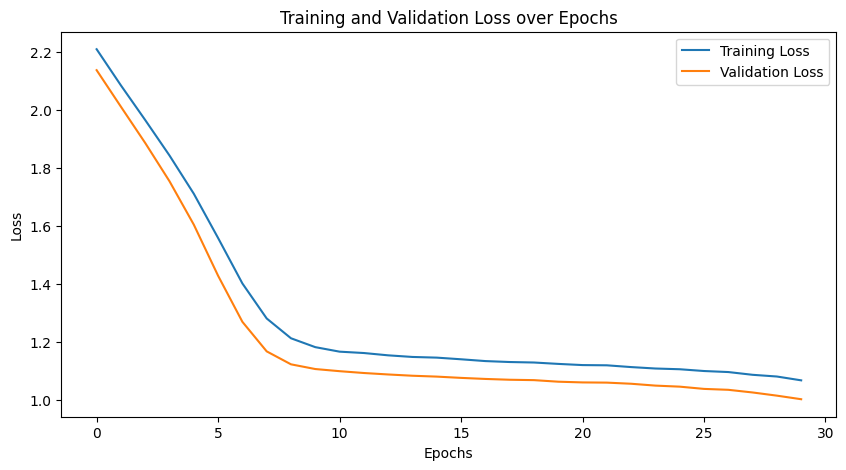

Validation Mean Loss: 1.0038576531917491 | Accuracy: 53.63333333333333%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.5; Optimizer: Adam
Validation Mean Loss: 0.317499115746072 | Accuracy: 86.63333333333333%
Epoch [1/30], Loss: 0.8115, Accuracy: 65.38%
Validation Mean Loss: 0.2313758999584837 | Accuracy: 90.83333333333333%
Epoch [2/30], Loss: 0.3559, Accuracy: 84.90%
Validation Mean Loss: 0.20743540012614525 | Accuracy: 92.93333333333334%
Epoch [3/30], Loss: 0.2725, Accuracy: 89.13%
Validation Mean Loss: 0.21561746030768497 | Accuracy: 92.23333333333333%
Epoch [4/30], Loss: 0.2239, Accuracy: 91.69%
Validation Mean Loss: 0.18593973387032747 | Accuracy: 93.7%
Epoch [5/30], Loss: 0.2056, Accuracy: 92.40%
Validation Mean Loss: 0.1801491482282414 | Accuracy: 93.86666666666666%
Epoch [6/30], Loss: 0.1948, Accuracy: 92.90%
Validation Mean Loss: 0.17541263914825

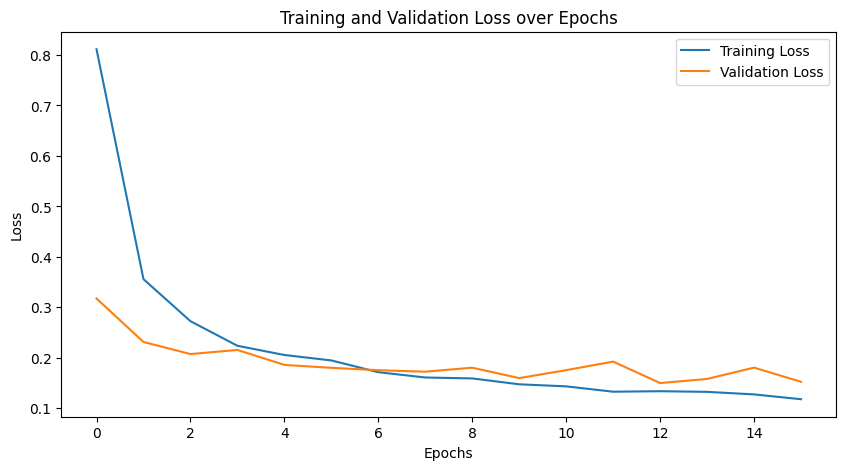

Validation Mean Loss: 0.1524351766045661 | Accuracy: 94.76666666666667%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.5; Optimizer: SGD
Validation Mean Loss: 2.140162632820454 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 2.2071, Accuracy: 42.25%
Validation Mean Loss: 2.0152693149891308 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 2.0843, Accuracy: 50.79%
Validation Mean Loss: 1.894878918820239 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.9682, Accuracy: 50.79%
Validation Mean Loss: 1.7772181579407225 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.8561, Accuracy: 50.79%
Validation Mean Loss: 1.6606861467057086 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.7449, Accuracy: 50.79%
Validation Mean Loss: 1.5469290880446738 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 1.6353, Accuracy: 50.79%
Validation Mean Loss: 1.

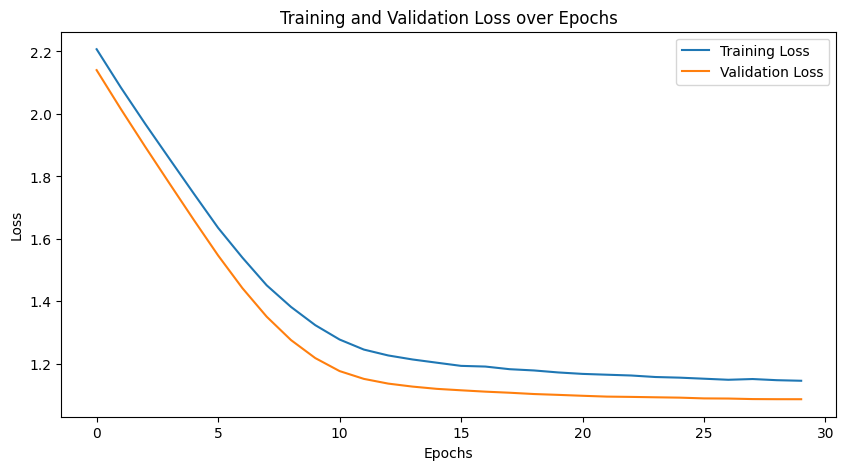

Validation Mean Loss: 1.086695819459063 | Accuracy: 53.333333333333336%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.25; Optimizer: Adam
Validation Mean Loss: 0.01709541479160296 | Accuracy: 99.7%
Epoch [1/30], Loss: 0.3609, Accuracy: 85.83%
Validation Mean Loss: 0.013834099649114522 | Accuracy: 99.66666666666667%
Epoch [2/30], Loss: 0.0283, Accuracy: 99.22%
Validation Mean Loss: 0.00456122702408228 | Accuracy: 99.83333333333333%
Epoch [3/30], Loss: 0.0139, Accuracy: 99.62%
Validation Mean Loss: 0.005403803393319515 | Accuracy: 99.86666666666667%
Epoch [4/30], Loss: 0.0111, Accuracy: 99.68%
Validation Mean Loss: 0.003130837102617381 | Accuracy: 99.96666666666667%
Epoch [5/30], Loss: 0.0080, Accuracy: 99.72%
Validation Mean Loss: 0.0012903140951713134 | Accuracy: 99.96666666666667%
Epoch [6/30], Loss: 0.0051, Accuracy: 99.87%
Validation Mean Loss: 0.0006841415

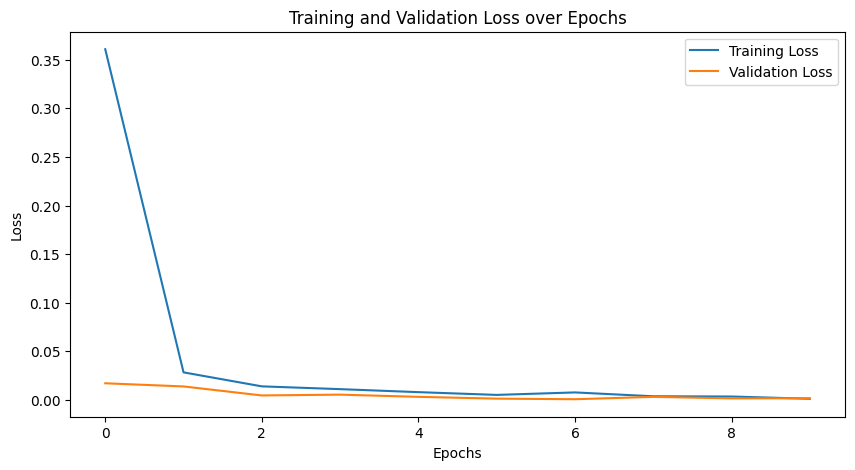

Validation Mean Loss: 0.0016863500295430957 | Accuracy: 99.96666666666667%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.25; Optimizer: SGD
Validation Mean Loss: 2.1136098694294057 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 2.2141, Accuracy: 41.94%
Validation Mean Loss: 1.7055231776643307 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 1.9738, Accuracy: 50.79%
Validation Mean Loss: 1.1848397476876036 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.4456, Accuracy: 50.81%
Validation Mean Loss: 1.1249905057409977 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.2274, Accuracy: 50.39%
Validation Mean Loss: 1.1123659686839327 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.1942, Accuracy: 50.52%
Validation Mean Loss: 1.1057529912350026 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 1.1812, Accuracy: 50.37%
Validation Mean Loss: 1.

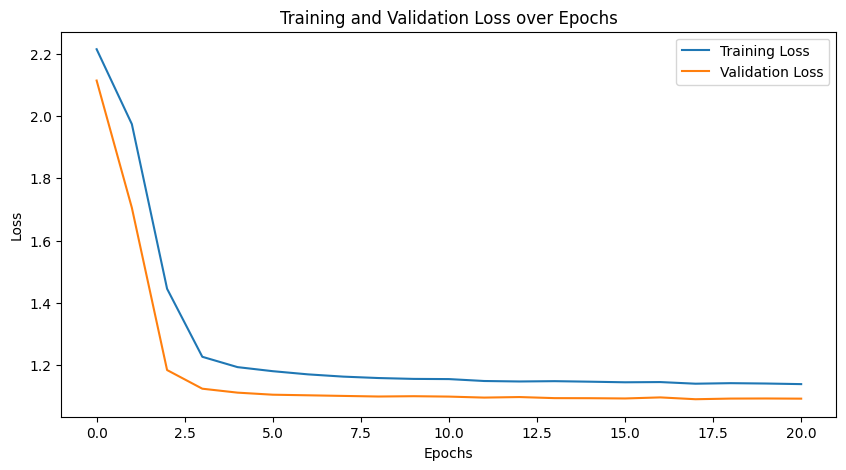

Validation Mean Loss: 1.0930844570728058 | Accuracy: 53.333333333333336%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.5; Optimizer: Adam
Validation Mean Loss: 0.06694820644194825 | Accuracy: 98.73333333333333%
Epoch [1/30], Loss: 0.5921, Accuracy: 75.74%
Validation Mean Loss: 0.03214306091622541 | Accuracy: 99.3%
Epoch [2/30], Loss: 0.1029, Accuracy: 96.83%
Validation Mean Loss: 0.016633391342492254 | Accuracy: 99.63333333333333%
Epoch [3/30], Loss: 0.0522, Accuracy: 98.52%
Validation Mean Loss: 0.010088929093248628 | Accuracy: 99.73333333333333%
Epoch [4/30], Loss: 0.0334, Accuracy: 99.10%
Validation Mean Loss: 0.004521781452586288 | Accuracy: 99.9%
Epoch [5/30], Loss: 0.0289, Accuracy: 99.13%
Validation Mean Loss: 0.0051076060542816284 | Accuracy: 99.9%
Epoch [6/30], Loss: 0.0227, Accuracy: 99.39%
Validation Mean Loss: 0.0028672633912274433 | Accuracy: 99.9

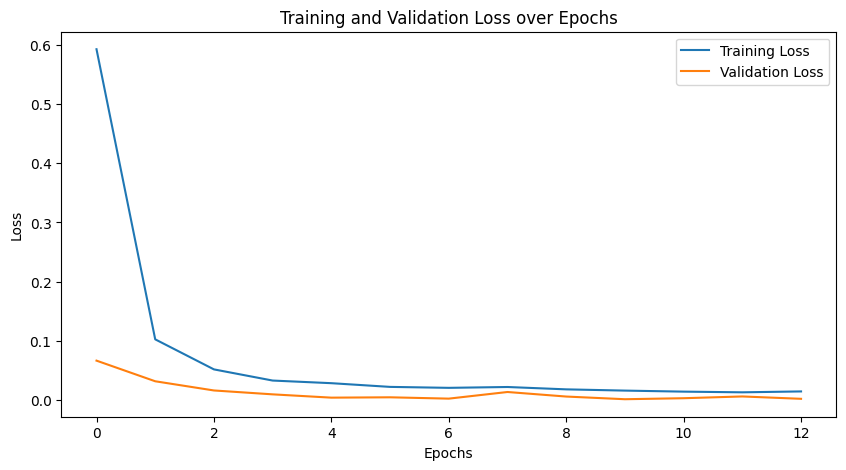

Validation Mean Loss: 0.002567080675248758 | Accuracy: 99.93333333333332%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.5; Optimizer: SGD
Validation Mean Loss: 2.0232383887818517 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 2.1600, Accuracy: 43.29%
Validation Mean Loss: 1.3564544167924435 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 1.7726, Accuracy: 50.73%
Validation Mean Loss: 1.1576627683132252 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.3637, Accuracy: 49.94%
Validation Mean Loss: 1.1279573535665552 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.2734, Accuracy: 48.44%
Validation Mean Loss: 1.1168841510377032 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.2393, Accuracy: 49.38%
Validation Mean Loss: 1.1094921522952141 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 1.2172, Accuracy: 49.58%
Validation Mean Loss: 1.10

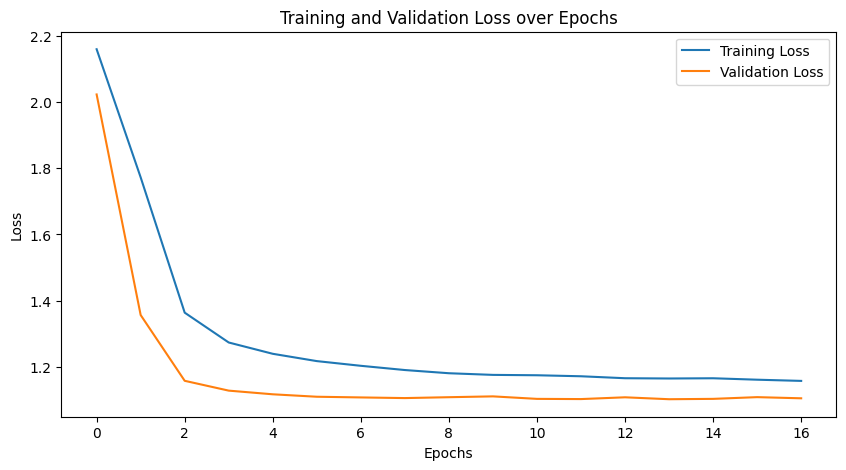

Validation Mean Loss: 1.104793977864245 | Accuracy: 53.333333333333336%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.25; Optimizer: Adam
Validation Mean Loss: 0.023641857323882312 | Accuracy: 99.56666666666666%
Epoch [1/30], Loss: 0.3637, Accuracy: 85.63%
Validation Mean Loss: 0.014142596438699351 | Accuracy: 99.53333333333333%
Epoch [2/30], Loss: 0.0221, Accuracy: 99.40%
Validation Mean Loss: 0.00458420150686213 | Accuracy: 99.83333333333333%
Epoch [3/30], Loss: 0.0147, Accuracy: 99.54%
Validation Mean Loss: 0.011023813483545608 | Accuracy: 99.76666666666667%
Epoch [4/30], Loss: 0.0047, Accuracy: 99.86%
Validation Mean Loss: 0.02181172309335918 | Accuracy: 99.33333333333333%
Epoch [5/30], Loss: 0.0064, Accuracy: 99.81%
Validation Mean Loss: 0.01804563537498572 | Accuracy: 99.43333333333332%
Epoch [6/30], Loss: 0.0039, Accuracy: 99.87%
Early stopping do

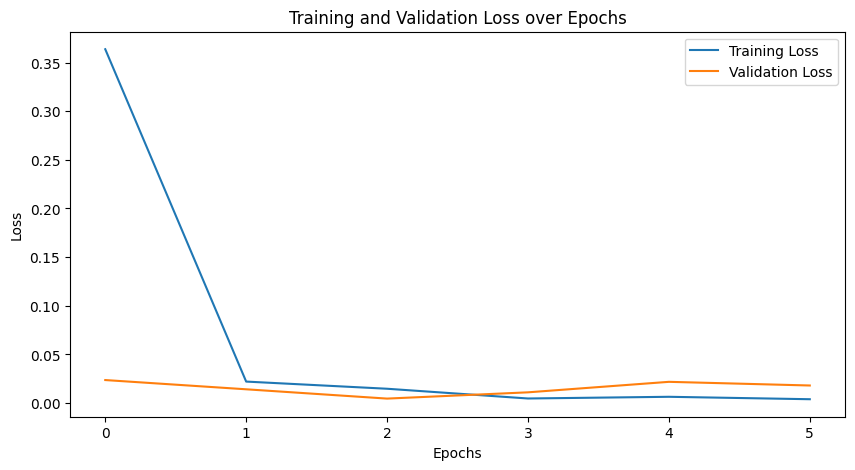

Validation Mean Loss: 0.01804563537498572 | Accuracy: 99.43333333333332%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.25; Optimizer: SGD
Validation Mean Loss: 2.1392863202602306 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 2.2373, Accuracy: 28.44%
Validation Mean Loss: 1.8095982835647908 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 2.0265, Accuracy: 50.76%
Validation Mean Loss: 1.2781529990916556 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.5684, Accuracy: 50.79%
Validation Mean Loss: 1.150220978133222 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.2805, Accuracy: 50.81%
Validation Mean Loss: 1.125708429737294 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.2099, Accuracy: 50.43%
Validation Mean Loss: 1.1146106707288863 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 1.1938, Accuracy: 50.52%
Validation Mean Loss: 

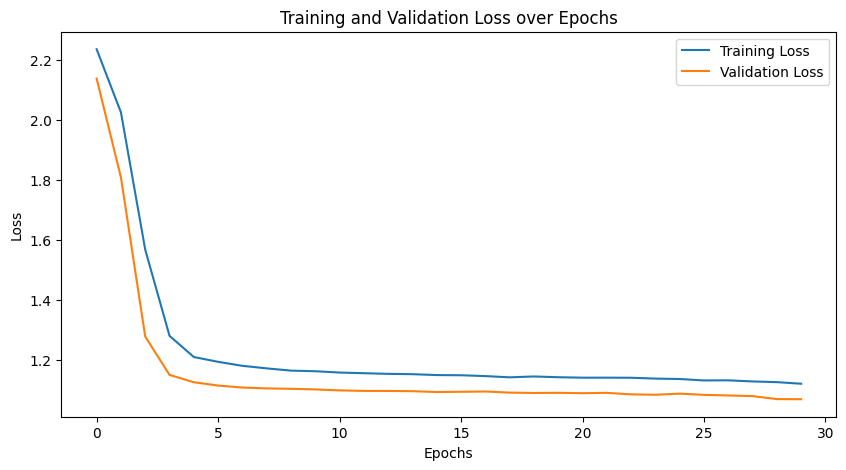

Validation Mean Loss: 1.068989487404519 | Accuracy: 53.333333333333336%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.5; Optimizer: Adam
Validation Mean Loss: 0.023867188661128278 | Accuracy: 99.66666666666667%
Epoch [1/30], Loss: 0.5250, Accuracy: 79.25%
Validation Mean Loss: 0.01924200469244518 | Accuracy: 99.6%
Epoch [2/30], Loss: 0.0586, Accuracy: 98.18%
Validation Mean Loss: 0.0044145869685637005 | Accuracy: 99.9%
Epoch [3/30], Loss: 0.0283, Accuracy: 99.13%
Validation Mean Loss: 0.003122276140504853 | Accuracy: 99.93333333333332%
Epoch [4/30], Loss: 0.0262, Accuracy: 99.38%
Validation Mean Loss: 0.00325759049855736 | Accuracy: 99.96666666666667%
Epoch [5/30], Loss: 0.0137, Accuracy: 99.59%
Validation Mean Loss: 0.0006067996126595254 | Accuracy: 100.0%
Epoch [6/30], Loss: 0.0135, Accuracy: 99.62%
Validation Mean Loss: 0.0005268883357313536 | Accurac

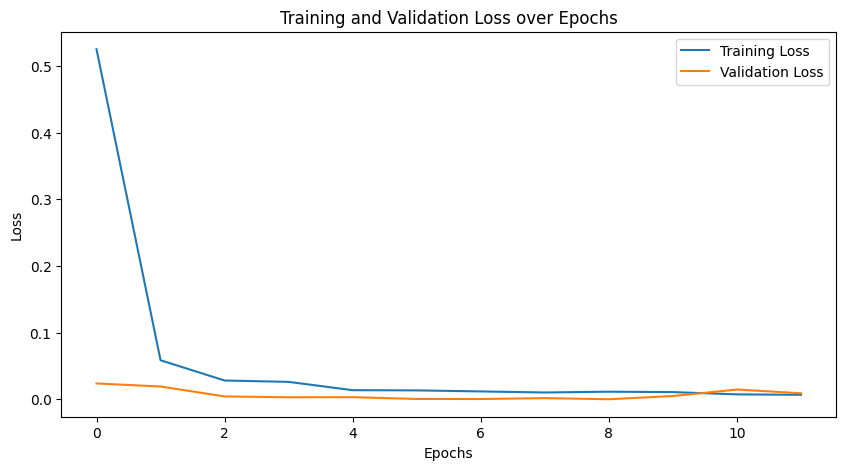

Validation Mean Loss: 0.009092044581777448 | Accuracy: 99.83333333333333%
Learning rate: 0.001; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.5; Optimizer: SGD
Validation Mean Loss: 1.9371048896870715 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 2.1379, Accuracy: 49.37%
Validation Mean Loss: 1.2428382825344166 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 1.6262, Accuracy: 50.23%
Validation Mean Loss: 1.1459808926633064 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.3141, Accuracy: 47.23%
Validation Mean Loss: 1.126570147402743 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.2667, Accuracy: 47.78%
Validation Mean Loss: 1.1165122022020055 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.2396, Accuracy: 48.50%
Validation Mean Loss: 1.1088509014312258 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 1.2137, Accuracy: 49.54%
Validation Mean Loss:

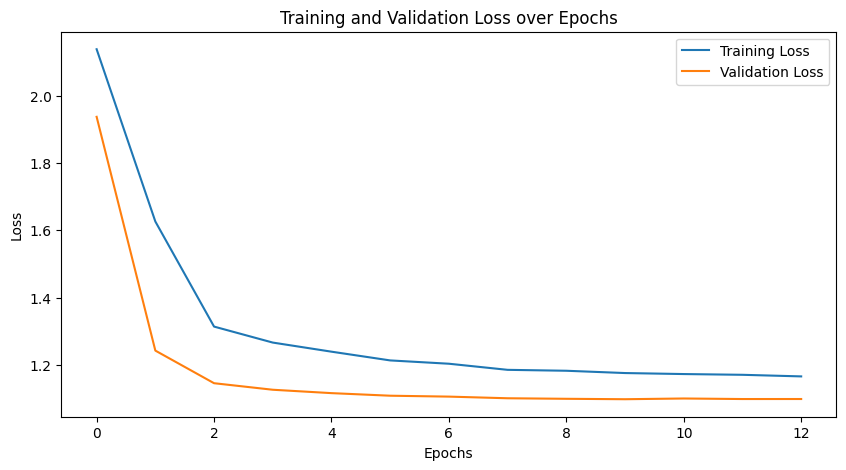

Validation Mean Loss: 1.0990476995072467 | Accuracy: 53.333333333333336%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.25; Optimizer: Adam
Validation Mean Loss: 0.302689985500926 | Accuracy: 88.36666666666667%
Epoch [1/30], Loss: 0.5665, Accuracy: 74.98%
Validation Mean Loss: 0.2769968116586592 | Accuracy: 90.73333333333333%
Epoch [2/30], Loss: 0.2863, Accuracy: 88.85%
Validation Mean Loss: 0.22814888754819937 | Accuracy: 92.73333333333333%
Epoch [3/30], Loss: 0.2504, Accuracy: 90.75%
Validation Mean Loss: 0.2281905312408158 | Accuracy: 92.23333333333333%
Epoch [4/30], Loss: 0.2305, Accuracy: 91.33%
Validation Mean Loss: 0.18276645651364581 | Accuracy: 93.46666666666667%
Epoch [5/30], Loss: 0.2282, Accuracy: 91.60%
Validation Mean Loss: 0.23737311094474206 | Accuracy: 90.4%
Epoch [6/30], Loss: 0.2101, Accuracy: 92.36%
Validation Mean Loss: 0.17237502647603445 |

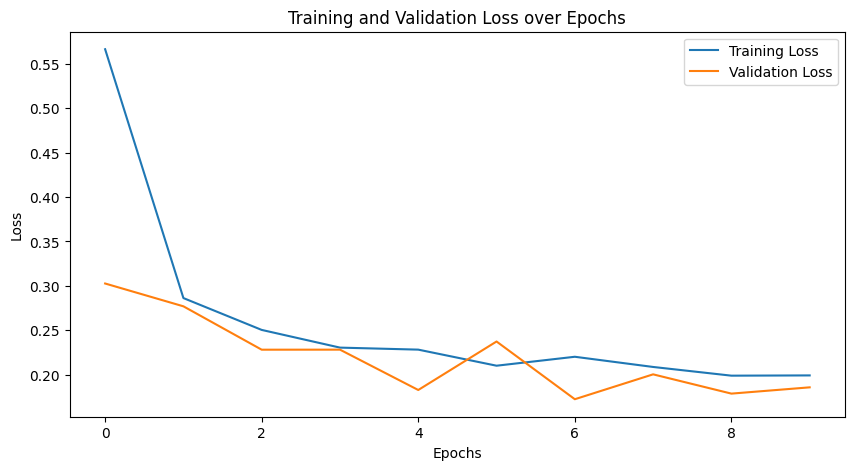

Validation Mean Loss: 0.18575583650492766 | Accuracy: 93.8%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.25; Optimizer: SGD
Validation Mean Loss: 1.1393006837114374 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.5884, Accuracy: 50.03%
Validation Mean Loss: 1.0985575299313728 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 1.1685, Accuracy: 50.79%
Validation Mean Loss: 1.089306504168409 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.1455, Accuracy: 50.81%
Validation Mean Loss: 1.0809652082463528 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.1390, Accuracy: 50.79%
Validation Mean Loss: 1.0686665735346206 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.1285, Accuracy: 50.78%
Validation Mean Loss: 1.0078804993883093 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 1.1009, Accuracy: 51.06%
Validation Mean Loss: 0.8150736708590325 

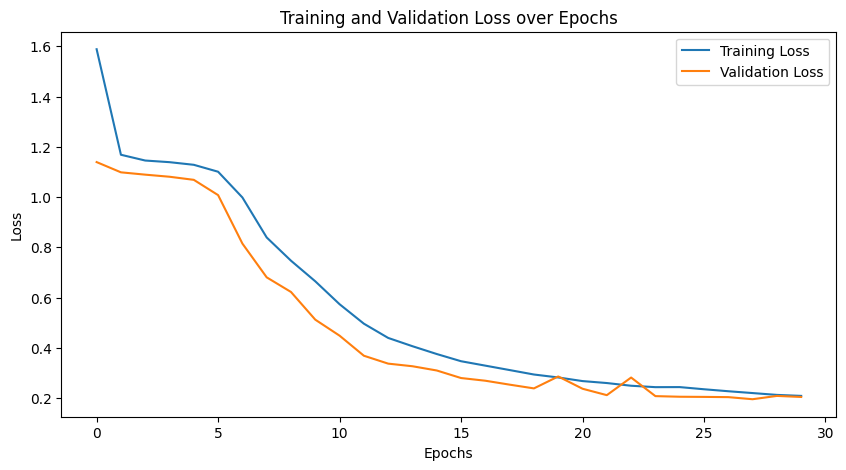

Validation Mean Loss: 0.2046260277720842 | Accuracy: 92.0%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.5; Optimizer: Adam
Validation Mean Loss: 0.3924364226454116 | Accuracy: 82.03333333333333%
Epoch [1/30], Loss: 0.6370, Accuracy: 72.79%
Validation Mean Loss: 0.2519300821970435 | Accuracy: 90.06666666666666%
Epoch [2/30], Loss: 0.3697, Accuracy: 85.55%
Validation Mean Loss: 0.3397481316066486 | Accuracy: 84.63333333333334%
Epoch [3/30], Loss: 0.3324, Accuracy: 86.93%
Validation Mean Loss: 0.331348001124694 | Accuracy: 86.93333333333332%
Epoch [4/30], Loss: 0.3072, Accuracy: 88.22%
Validation Mean Loss: 0.21947312612641365 | Accuracy: 92.26666666666667%
Epoch [5/30], Loss: 0.2993, Accuracy: 88.79%
Validation Mean Loss: 0.26098663427252716 | Accuracy: 90.36666666666666%
Epoch [6/30], Loss: 0.2898, Accuracy: 89.13%
Validation Mean Loss: 0.26348976225176074 | Ac

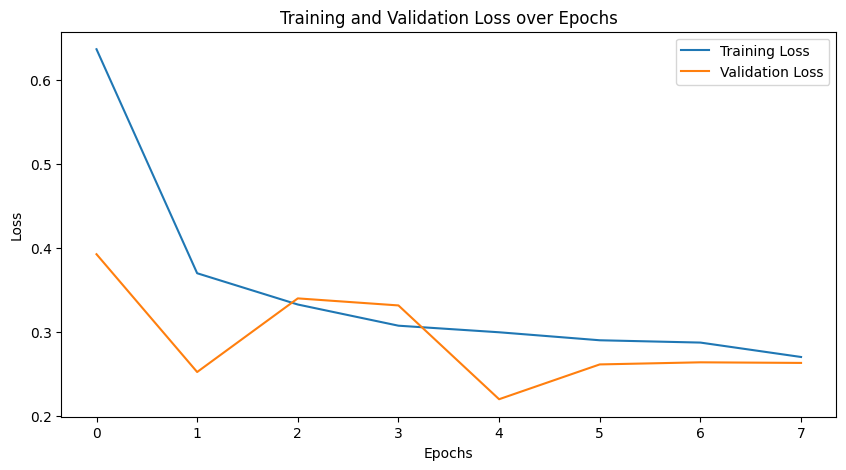

Validation Mean Loss: 0.26277111610893084 | Accuracy: 91.33333333333333%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.5; Optimizer: SGD
Validation Mean Loss: 1.3165258936425472 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.7895, Accuracy: 48.79%
Validation Mean Loss: 1.1053012806050322 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 1.2492, Accuracy: 50.72%
Validation Mean Loss: 1.0900036134618394 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.1697, Accuracy: 50.69%
Validation Mean Loss: 1.0709402288528198 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.1485, Accuracy: 50.65%
Validation Mean Loss: 1.0614861611356126 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.1319, Accuracy: 50.83%
Validation Mean Loss: 0.96893465709179 | Accuracy: 60.3%
Epoch [6/30], Loss: 1.0933, Accuracy: 52.11%
Validation Mean Loss: 0.7725268212404657 | A

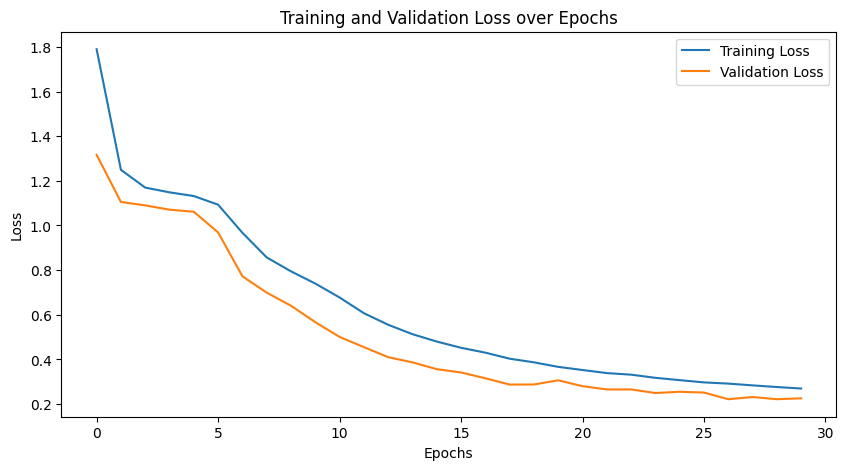

Validation Mean Loss: 0.2259182875302244 | Accuracy: 91.06666666666666%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.25; Optimizer: Adam
Validation Mean Loss: 0.44743795978240786 | Accuracy: 83.86666666666667%
Epoch [1/30], Loss: 0.4920, Accuracy: 79.24%
Validation Mean Loss: 0.31456803223315616 | Accuracy: 90.36666666666666%
Epoch [2/30], Loss: 0.2770, Accuracy: 89.28%
Validation Mean Loss: 0.2419720573073372 | Accuracy: 90.8%
Epoch [3/30], Loss: 0.2468, Accuracy: 90.79%
Validation Mean Loss: 0.18881353218742508 | Accuracy: 93.06666666666666%
Epoch [4/30], Loss: 0.2242, Accuracy: 91.59%
Validation Mean Loss: 0.2065245983874465 | Accuracy: 93.0%
Epoch [5/30], Loss: 0.2081, Accuracy: 92.41%
Validation Mean Loss: 0.18406979747592134 | Accuracy: 92.66666666666666%
Epoch [6/30], Loss: 0.2052, Accuracy: 92.65%
Validation Mean Loss: 0.29991444652563237 | Accur

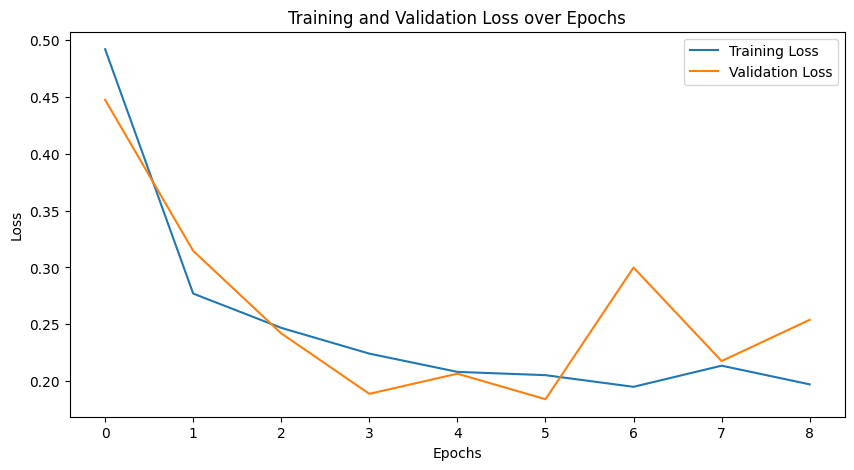

Validation Mean Loss: 0.25392923445782645 | Accuracy: 92.0%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.25; Optimizer: SGD
Validation Mean Loss: 1.1500555308575326 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.6812, Accuracy: 49.85%
Validation Mean Loss: 1.1086723417677777 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 1.1731, Accuracy: 50.76%
Validation Mean Loss: 1.0904991430170992 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.1459, Accuracy: 50.80%
Validation Mean Loss: 1.0754152923188312 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.1347, Accuracy: 50.75%
Validation Mean Loss: 1.0404573000491935 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.1165, Accuracy: 51.00%
Validation Mean Loss: 0.8695368202442818 | Accuracy: 65.4%
Epoch [6/30], Loss: 1.0436, Accuracy: 54.79%
Validation Mean Loss: 0.7561184053725385 | Accur

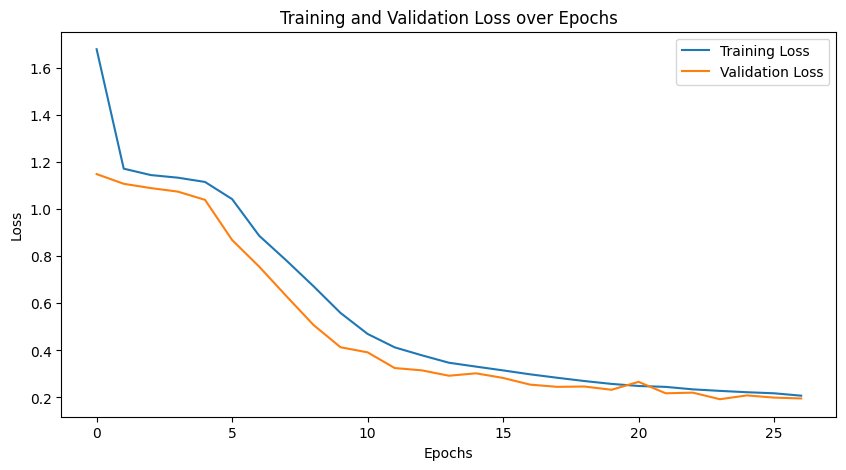

Validation Mean Loss: 0.19550474344732913 | Accuracy: 92.2%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.5; Optimizer: Adam
Validation Mean Loss: 0.2934280952557604 | Accuracy: 86.86666666666667%
Epoch [1/30], Loss: 0.5998, Accuracy: 74.36%
Validation Mean Loss: 0.3630561842087734 | Accuracy: 90.23333333333333%
Epoch [2/30], Loss: 0.3589, Accuracy: 85.79%
Validation Mean Loss: 0.27718569825656036 | Accuracy: 90.03333333333333%
Epoch [3/30], Loss: 0.3334, Accuracy: 87.32%
Validation Mean Loss: 0.23862215966243852 | Accuracy: 92.23333333333333%
Epoch [4/30], Loss: 0.2693, Accuracy: 89.61%
Validation Mean Loss: 0.23417701245226125 | Accuracy: 91.36666666666666%
Epoch [5/30], Loss: 0.2759, Accuracy: 89.63%
Validation Mean Loss: 0.23454900121965266 | Accuracy: 91.8%
Epoch [6/30], Loss: 0.2721, Accuracy: 89.83%
Validation Mean Loss: 0.20099099140931317 | Accur

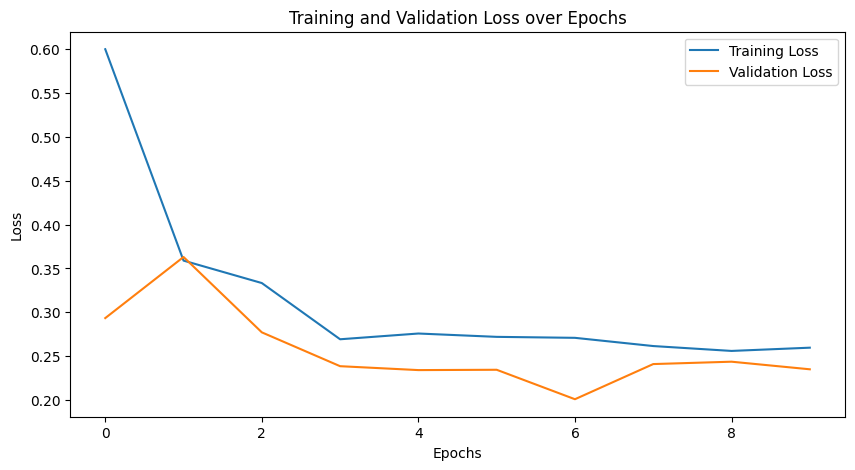

Validation Mean Loss: 0.23509144428324827 | Accuracy: 91.7%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 3; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.5; Optimizer: SGD
Validation Mean Loss: 1.166308063775935 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.7665, Accuracy: 46.77%
Validation Mean Loss: 1.099218171327672 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 1.2030, Accuracy: 50.40%
Validation Mean Loss: 1.065627691593576 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.1497, Accuracy: 50.83%
Validation Mean Loss: 1.0354254144303343 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.1210, Accuracy: 50.82%
Validation Mean Loss: 0.8962333081884587 | Accuracy: 57.9%
Epoch [5/30], Loss: 1.0630, Accuracy: 52.04%
Validation Mean Loss: 0.7263179142424401 | Accuracy: 65.86666666666666%
Epoch [6/30], Loss: 0.9187, Accuracy: 56.69%
Validation Mean Loss: 0.6276580944974371 | Accuracy: 

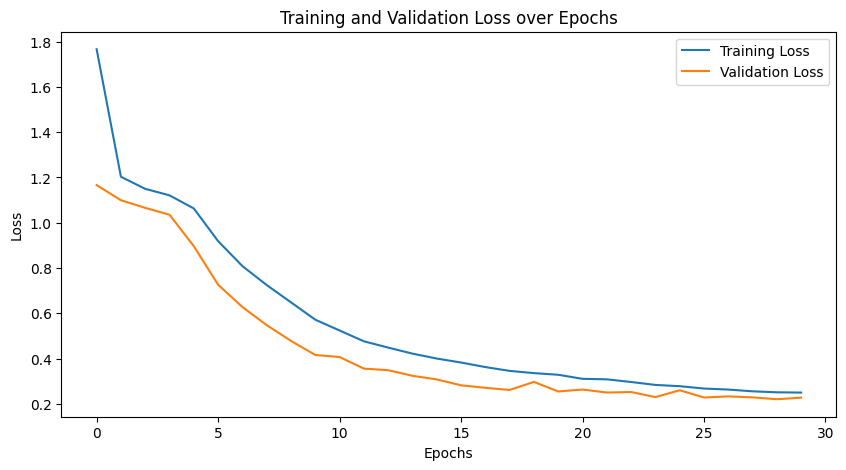

Validation Mean Loss: 0.227176626906433 | Accuracy: 90.86666666666666%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.25; Optimizer: Adam
Validation Mean Loss: 0.05111885602830993 | Accuracy: 98.73333333333333%
Epoch [1/30], Loss: 0.2445, Accuracy: 90.80%
Validation Mean Loss: 0.00852592349586865 | Accuracy: 99.83333333333333%
Epoch [2/30], Loss: 0.0394, Accuracy: 98.94%
Validation Mean Loss: 0.02111443057073665 | Accuracy: 99.46666666666667%
Epoch [3/30], Loss: 0.0338, Accuracy: 99.15%
Validation Mean Loss: 0.014098392672536703 | Accuracy: 99.66666666666667%
Epoch [4/30], Loss: 0.0247, Accuracy: 99.48%
Validation Mean Loss: 0.018508767071176595 | Accuracy: 99.83333333333333%
Epoch [5/30], Loss: 0.0393, Accuracy: 99.20%
Early stopping done


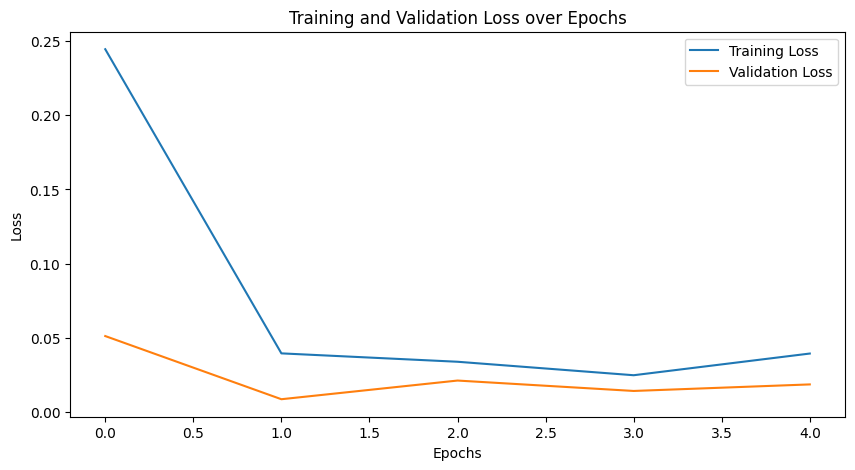

Validation Mean Loss: 0.018508767071176595 | Accuracy: 99.83333333333333%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.25; Optimizer: SGD
Validation Mean Loss: 1.1128634899220569 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.4337, Accuracy: 50.60%
Validation Mean Loss: 1.144557497919874 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 1.1595, Accuracy: 50.76%
Validation Mean Loss: 1.1121496856212616 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.1557, Accuracy: 50.79%
Validation Mean Loss: 1.1097851934585166 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.1533, Accuracy: 50.83%
Validation Mean Loss: 1.1124200060012492 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.1491, Accuracy: 50.75%
Validation Mean Loss: 1.1161945747568252 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 1.1475, Accuracy: 50.82%
Validation Mean Loss: 1.091

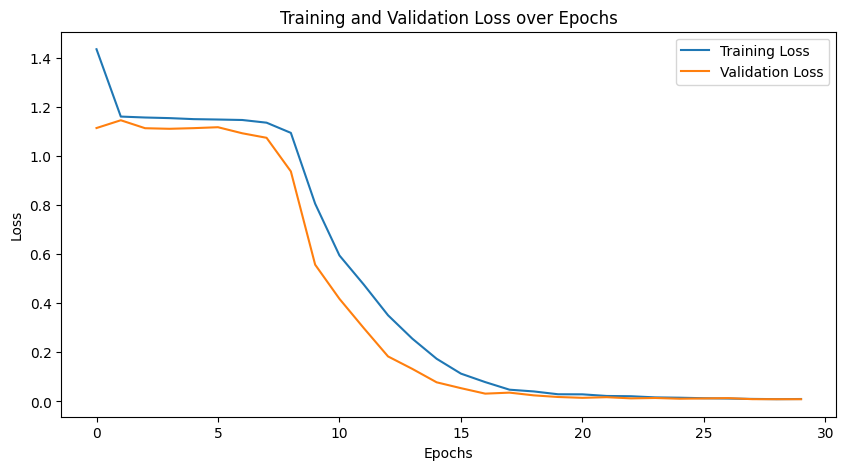

Validation Mean Loss: 0.009029138398463669 | Accuracy: 99.86666666666667%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.5; Optimizer: Adam
Validation Mean Loss: 0.02148869293625497 | Accuracy: 99.7%
Epoch [1/30], Loss: 0.3137, Accuracy: 87.71%
Validation Mean Loss: 0.015569517253221962 | Accuracy: 99.7%
Epoch [2/30], Loss: 0.0837, Accuracy: 97.85%
Validation Mean Loss: 0.0038018364663012687 | Accuracy: 99.86666666666667%
Epoch [3/30], Loss: 0.0812, Accuracy: 97.81%
Validation Mean Loss: 0.015084946080213308 | Accuracy: 99.63333333333333%
Epoch [4/30], Loss: 0.0701, Accuracy: 98.37%
Validation Mean Loss: 0.002661225335937026 | Accuracy: 99.86666666666667%
Epoch [5/30], Loss: 0.0493, Accuracy: 98.74%
Validation Mean Loss: 0.007778584005895507 | Accuracy: 99.83333333333333%
Epoch [6/30], Loss: 0.0798, Accuracy: 98.44%
Validation Mean Loss: 0.005869754563766062 | A

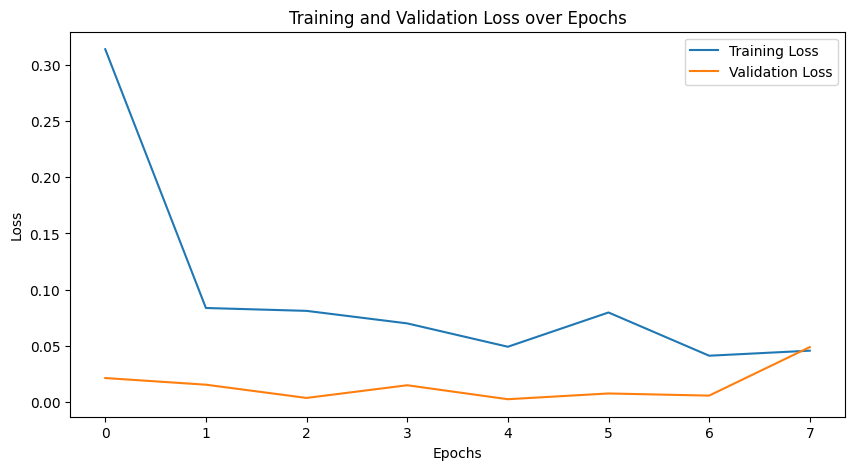

Validation Mean Loss: 0.048992332756163735 | Accuracy: 99.23333333333333%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: relu; Pooling type: max; Dropout rate: 0.5; Optimizer: SGD
Validation Mean Loss: 1.1047026432575064 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.4171, Accuracy: 49.83%
Validation Mean Loss: 1.1106166903008805 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 1.1762, Accuracy: 50.58%
Validation Mean Loss: 1.1147377275406045 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.1650, Accuracy: 50.45%
Validation Mean Loss: 1.0928554452480155 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.1588, Accuracy: 50.61%
Validation Mean Loss: 1.1003602172466034 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.1537, Accuracy: 50.67%
Validation Mean Loss: 1.0902773807657526 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 1.1500, Accuracy: 50.71%
Validation Mean Loss: 1.034

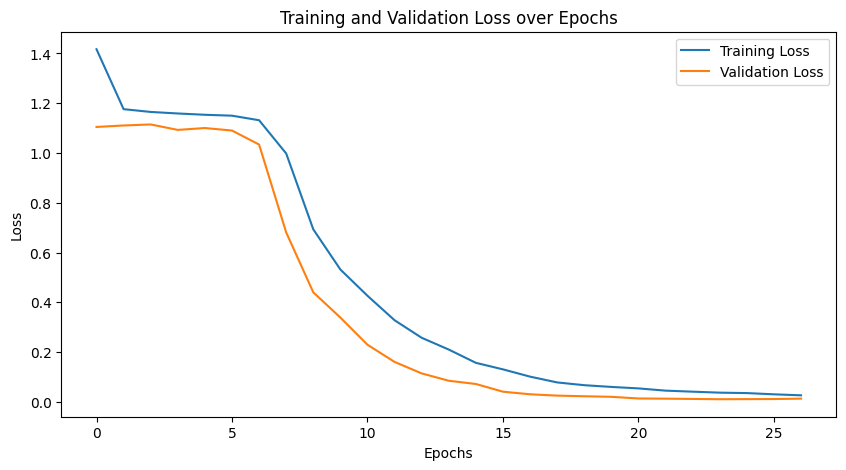

Validation Mean Loss: 0.0126508242028141 | Accuracy: 99.86666666666667%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.25; Optimizer: Adam
Validation Mean Loss: 0.01570646062533872 | Accuracy: 99.63333333333333%
Epoch [1/30], Loss: 0.1629, Accuracy: 94.12%
Validation Mean Loss: 0.005403278309028225 | Accuracy: 99.73333333333333%
Epoch [2/30], Loss: 0.0346, Accuracy: 99.19%
Validation Mean Loss: 0.013415012286955545 | Accuracy: 99.56666666666666%
Epoch [3/30], Loss: 0.0471, Accuracy: 99.06%
Validation Mean Loss: 0.01685979901534379 | Accuracy: 99.63333333333333%
Epoch [4/30], Loss: 0.0289, Accuracy: 99.37%
Validation Mean Loss: 0.001649784326492257 | Accuracy: 99.93333333333332%
Epoch [5/30], Loss: 0.0180, Accuracy: 99.57%
Validation Mean Loss: 0.033130157847375975 | Accuracy: 99.3%
Epoch [6/30], Loss: 0.0563, Accuracy: 99.26%
Validation Mean Loss: 0.002544

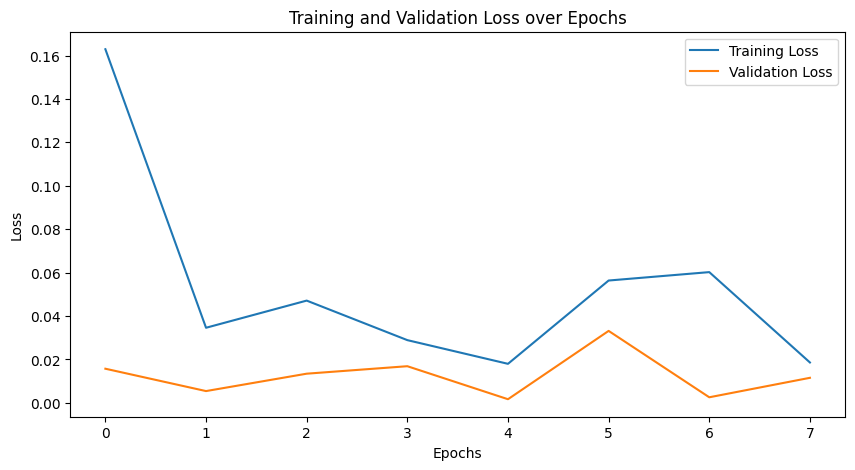

Validation Mean Loss: 0.01151563025965172 | Accuracy: 99.8%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.25; Optimizer: SGD
Validation Mean Loss: 1.133656121948932 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.4980, Accuracy: 50.33%
Validation Mean Loss: 1.096270019069631 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 1.1617, Accuracy: 50.65%
Validation Mean Loss: 1.1053161557684554 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.1522, Accuracy: 50.71%
Validation Mean Loss: 1.0741331272936883 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.1400, Accuracy: 50.79%
Validation Mean Loss: 0.851884883134923 | Accuracy: 71.36666666666667%
Epoch [5/30], Loss: 1.0769, Accuracy: 54.40%
Validation Mean Loss: 0.5393515798322698 | Accuracy: 79.23333333333333%
Epoch [6/30], Loss: 0.7576, Accuracy: 71.96%
Validation Mean Loss: 0.349669691908391

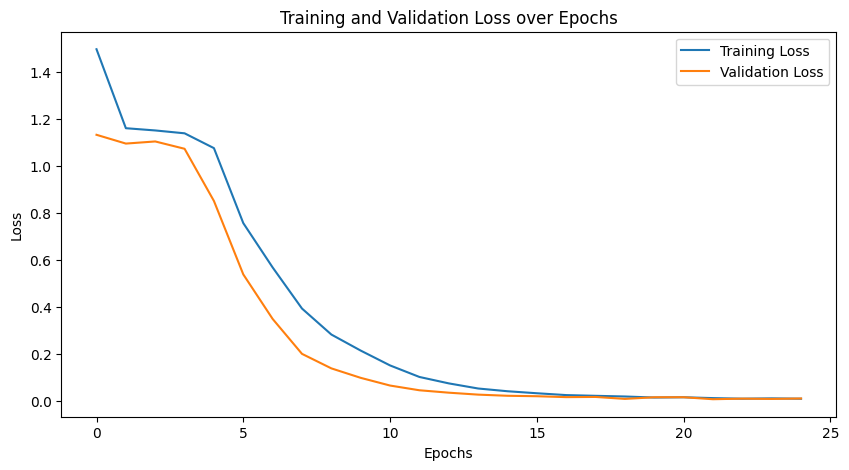

Validation Mean Loss: 0.011023013216123203 | Accuracy: 99.86666666666667%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.5; Optimizer: Adam
Validation Mean Loss: 0.0682146765672982 | Accuracy: 97.66666666666667%
Epoch [1/30], Loss: 0.4086, Accuracy: 84.58%
Validation Mean Loss: 0.009895916394711959 | Accuracy: 99.76666666666667%
Epoch [2/30], Loss: 0.0819, Accuracy: 97.38%
Validation Mean Loss: 0.004689614371471673 | Accuracy: 99.9%
Epoch [3/30], Loss: 0.0612, Accuracy: 98.43%
Validation Mean Loss: 0.00905688538230233 | Accuracy: 99.83333333333333%
Epoch [4/30], Loss: 0.0463, Accuracy: 98.68%
Validation Mean Loss: 0.005405173607429423 | Accuracy: 99.86666666666667%
Epoch [5/30], Loss: 0.0462, Accuracy: 98.79%
Validation Mean Loss: 0.006152521141353342 | Accuracy: 99.9%
Epoch [6/30], Loss: 0.0410, Accuracy: 98.96%
Early stopping done


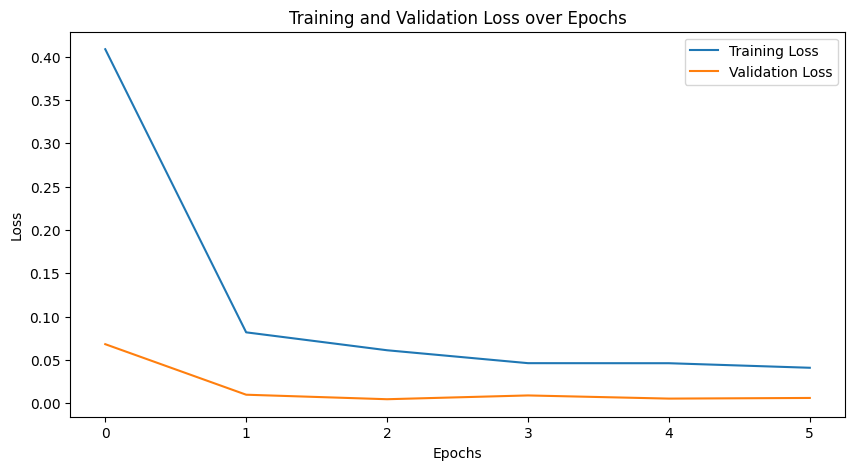

Validation Mean Loss: 0.006152521141353342 | Accuracy: 99.9%
Learning rate: 0.01; Kernel size for conv layer: 2; Kernel size for pool layer: 2; Number of conv layers: 2; Stride: 2; Activation: leaky_relu; Pooling type: max; Dropout rate: 0.5; Optimizer: SGD
Validation Mean Loss: 1.128400961135296 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.5733, Accuracy: 48.05%
Validation Mean Loss: 1.0968604791671672 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 1.1863, Accuracy: 50.47%
Validation Mean Loss: 1.1082950944596148 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 1.1626, Accuracy: 50.71%
Validation Mean Loss: 1.0892597912473883 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 1.1537, Accuracy: 50.61%
Validation Mean Loss: 1.0573659019267305 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 1.1418, Accuracy: 50.80%
Validation Mean Loss: 0.7923939665581318 | Accuracy: 76.26666666666667%
Epoch [6/30], Loss: 1.0621, Accuracy: 55.25%
Validation Mean Loss: 0.485609939044

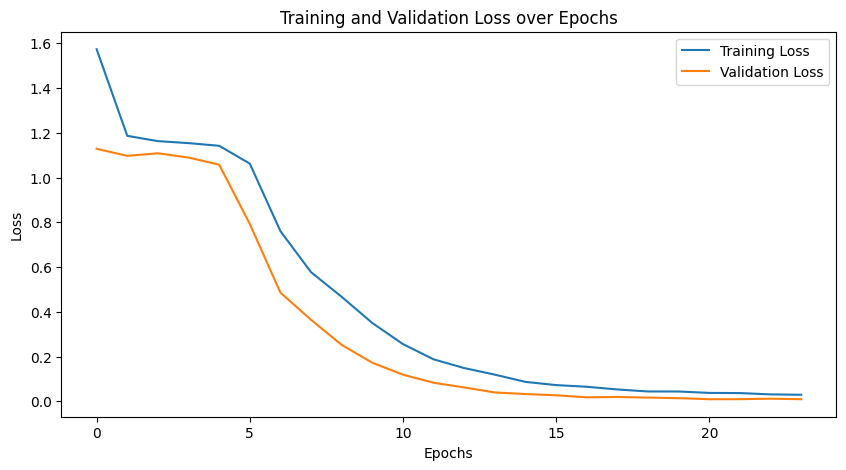

Validation Mean Loss: 0.009320579594849221 | Accuracy: 99.86666666666667%


In [49]:
print(torch.cuda.is_available())
best_parameters = {'Learning rate' : 0.001, 
                   'Number of convolution layers':3, 
                   'Stride':2, 
                   'Activation':'relu', 
                   'Pooling type':'max', 
                   'Dropout Rate':0.25, 
                   'Optimizer':'Adam'}
best_val_accuracy = float(-100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for lr in learning_rates:
    for conv_k in conv_kernel_sizes:
        for pool_k in pool_kernel_sizes:
            for n_layers in num_conv_layers:
                for stride in strides:
                    for activation in activations:
                        for pool_type in pooling_types:
                            for dropout in dropout_rates:
                                for opt in optimizers:
                                    print(f"Learning rate: {lr}; Kernel size for conv layer: {conv_k}; Kernel size for pool layer: {pool_k}; Number of conv layers: {n_layers}; Stride: {stride}; Activation: {activation}; Pooling type: {pool_type}; Dropout rate: {dropout}; Optimizer: {opt}")
                                    model = CNN(optimizer = opt, activation=activation, task='classification', pool_type=pool_type,stride=stride,num_conv_layers=n_layers, conv_kernel_size=conv_k, pool_kernel_size=pool_k,num_classes=10, dropout_rate=dropout).to(device)
                                    model.train_model(train,val,learning_rate = lr)
                                    _, accuracy = model.evaluate_model(val)
                                    if accuracy > best_val_accuracy:
                                        best_parameters = {'Learning rate':lr,
                                                           'Number of convolution layers':n_layers,
                                                           'Stride':stride,
                                                           'Activation':activation,
                                                           'Pooling type':pool_type,
                                                           'Dropout Rate':dropout,
                                                           'Optimizer':opt}
                                        best_val_accuracy = accuracy

In [50]:
print("Best validation accuracy achieved =",best_val_accuracy)
print("The best parameteres are\n",best_parameters)

Best validation accuracy achieved = 99.96666666666667
The best parameteres are
 {'Learning rate': 0.001, 'Number of convolution layers': 2, 'Stride': 2, 'Activation': 'relu', 'Pooling type': 'max', 'Dropout Rate': 0.25, 'Optimizer': 'Adam'}


### Best parameters for regression (Cross entropy loss)
````Best validation accuracy achieved = 99.97%````
<br>

### The best parameteres are:

````'Learning rate': 0.001````
<br>
````'Number of convolution layers': 2````
<br>
````'Stride': 2````
<br>
````'Activation': 'relu'````
<br>
````'Pooling type': 'max'````
<br>
````'Dropout Rate': 0.25````
<br>
````'Optimizer': 'Adam'````

### Using the best parameters and running the model on the test set

Validation Mean Loss: 0.0316342077565307 | Accuracy: 98.9%
Epoch [1/30], Loss: 0.3298, Accuracy: 87.48%
Validation Mean Loss: 0.011259822622416826 | Accuracy: 99.76666666666667%
Epoch [2/30], Loss: 0.0301, Accuracy: 99.26%
Validation Mean Loss: 0.009274755487637022 | Accuracy: 99.83333333333333%
Epoch [3/30], Loss: 0.0135, Accuracy: 99.69%
Validation Mean Loss: 0.0035153290973799723 | Accuracy: 99.93333333333332%
Epoch [4/30], Loss: 0.0120, Accuracy: 99.67%
Validation Mean Loss: 0.0077260264785412825 | Accuracy: 99.9%
Epoch [5/30], Loss: 0.0055, Accuracy: 99.87%
Validation Mean Loss: 0.004346174620488281 | Accuracy: 99.86666666666667%
Epoch [6/30], Loss: 0.0062, Accuracy: 99.83%
Validation Mean Loss: 0.00564449363071593 | Accuracy: 99.93333333333332%
Epoch [7/30], Loss: 0.0040, Accuracy: 99.84%
Early stopping done


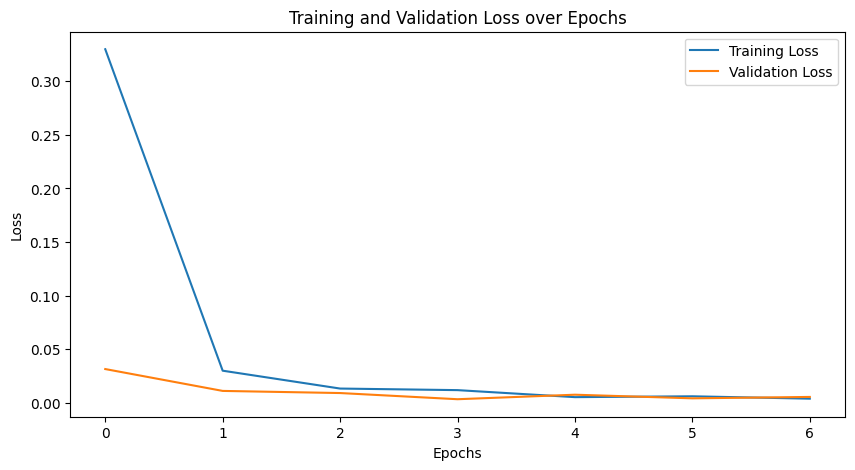

Validation Mean Loss: 0.0009269669292305673 | Accuracy: 99.95652173913044%
Accuracy on Test data: 99.95652173913044


In [12]:
model = CNN(optimizer = 'Adam', activation='relu', task='classification', pool_type='max',stride=2,num_conv_layers=2, conv_kernel_size=2, pool_kernel_size=2,num_classes=10, dropout_rate=0.25).to(device)
model.train_model(train,val,learning_rate = 0.001)
_, accuracy = model.evaluate_model(test)
print(f'Accuracy on Test data: {accuracy}')

In [16]:
print(f'Accuracy on Test data: {accuracy:.2f}%')

Accuracy on Test data: 99.96%


### Applying hyperparameter tuning for regression

Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation relu; Pooling type max; Dropout rate 0.25; Optimizer Adam
Validation Mean Loss: 0.1479885606689656 | Accuracy: 78.73333333333333%
Epoch [1/30], Loss: 0.4374, Accuracy: 59.54%
Validation Mean Loss: 0.11659608398901021 | Accuracy: 85.73333333333333%
Epoch [2/30], Loss: 0.2035, Accuracy: 73.87%
Validation Mean Loss: 0.103541191171934 | Accuracy: 87.96666666666667%
Epoch [3/30], Loss: 0.1700, Accuracy: 78.13%
Validation Mean Loss: 0.1563563890992961 | Accuracy: 78.63333333333333%
Epoch [4/30], Loss: 0.1511, Accuracy: 80.44%
Validation Mean Loss: 0.12114800372101525 | Accuracy: 85.0%
Epoch [5/30], Loss: 0.1379, Accuracy: 83.07%
Validation Mean Loss: 0.07257644067260813 | Accuracy: 93.13333333333334%
Epoch [6/30], Loss: 0.1304, Accuracy: 84.31%
Validation Mean Loss: 0.08047139165880272 | Accuracy: 92.10000000000001%
Epoch [7/30], Loss: 0.1149, Accuracy: 86.14%
Valida

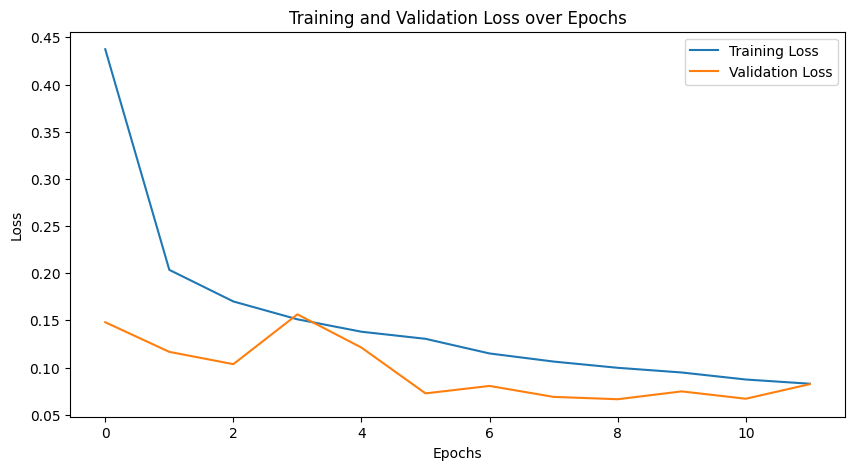

Validation Mean Loss: 0.0823509273268428 | Accuracy: 91.23333333333333%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation relu; Pooling type max; Dropout rate 0.25; Optimizer SGD
Validation Mean Loss: 0.6949567921618198 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.8918, Accuracy: 19.88%
Validation Mean Loss: 0.5139337790085924 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 0.6088, Accuracy: 50.10%
Validation Mean Loss: 0.49314090088406143 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 0.5750, Accuracy: 50.82%
Validation Mean Loss: 0.4736006651048925 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 0.5579, Accuracy: 50.95%
Validation Mean Loss: 0.44231990576682095 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 0.5321, Accuracy: 51.12%
Validation Mean Loss: 0.40647943396160896 | Accuracy: 53.36666666666666%
Epoch [6/30], Loss: 0.5057, Accuracy: 51.76%
Validation Mean Loss: 0.3698928501

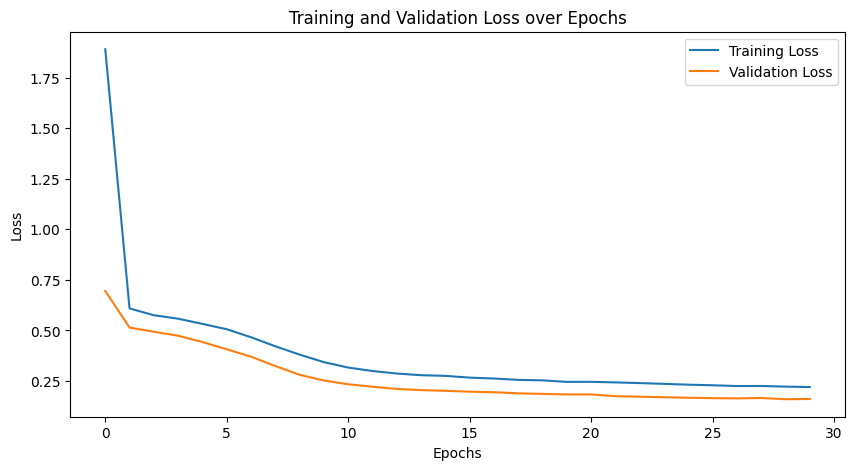

Validation Mean Loss: 0.16033953812686688 | Accuracy: 78.76666666666667%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation relu; Pooling type max; Dropout rate 0.5; Optimizer Adam
Validation Mean Loss: 0.14823338769851846 | Accuracy: 79.76666666666667%
Epoch [1/30], Loss: 0.6263, Accuracy: 50.86%
Validation Mean Loss: 0.12452895503411902 | Accuracy: 84.93333333333334%
Epoch [2/30], Loss: 0.3110, Accuracy: 64.80%
Validation Mean Loss: 0.08595645643691434 | Accuracy: 91.53333333333333%
Epoch [3/30], Loss: 0.2560, Accuracy: 69.31%
Validation Mean Loss: 0.084839190812187 | Accuracy: 91.33333333333333%
Epoch [4/30], Loss: 0.2123, Accuracy: 73.89%
Validation Mean Loss: 0.08955956669524312 | Accuracy: 90.53333333333333%
Epoch [5/30], Loss: 0.1875, Accuracy: 76.66%
Validation Mean Loss: 0.08046749166827252 | Accuracy: 91.93333333333334%
Epoch [6/30], Loss: 0.1689, Accuracy: 79.52%
Validation Mean Loss: 0.0732050604840

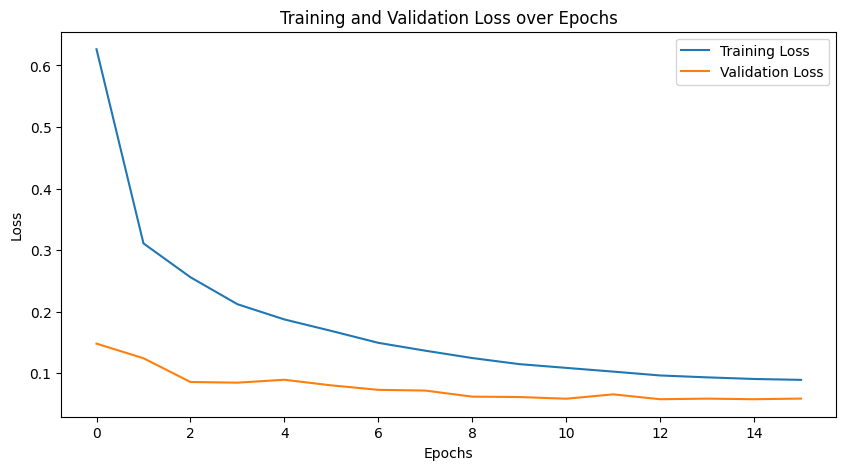

Validation Mean Loss: 0.0590122093723968 | Accuracy: 93.8%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation relu; Pooling type max; Dropout rate 0.5; Optimizer SGD
Validation Mean Loss: 0.8004692450482794 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 2.1803, Accuracy: 16.62%
Validation Mean Loss: 0.5681143107952827 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 0.6913, Accuracy: 47.40%
Validation Mean Loss: 0.5637284419846107 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 0.6551, Accuracy: 49.71%
Validation Mean Loss: 0.5598718274132091 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 0.6494, Accuracy: 50.14%
Validation Mean Loss: 0.5587230197976324 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 0.6452, Accuracy: 50.34%
Validation Mean Loss: 0.5559418906997691 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 0.6327, Accuracy: 50.56%
Validation Mean Loss: 0.5504699677570742 | Accurac

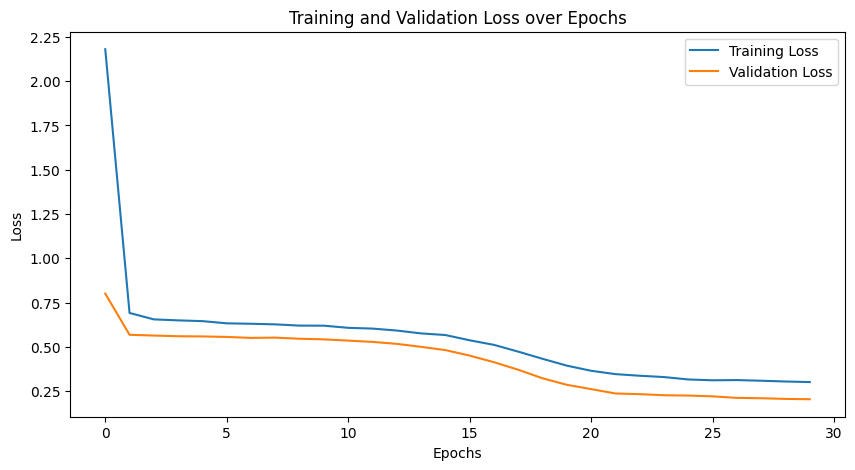

Validation Mean Loss: 0.2042513664891111 | Accuracy: 74.36666666666667%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.25; Optimizer Adam
Validation Mean Loss: 0.1279516375445305 | Accuracy: 84.7%
Epoch [1/30], Loss: 0.3855, Accuracy: 62.25%
Validation Mean Loss: 0.11007569260657468 | Accuracy: 87.43333333333332%
Epoch [2/30], Loss: 0.1756, Accuracy: 77.45%
Validation Mean Loss: 0.08919035421406969 | Accuracy: 90.7%
Epoch [3/30], Loss: 0.1525, Accuracy: 80.47%
Validation Mean Loss: 0.08426028009543711 | Accuracy: 91.36666666666666%
Epoch [4/30], Loss: 0.1332, Accuracy: 83.20%
Validation Mean Loss: 0.09909676576152127 | Accuracy: 89.03333333333333%
Epoch [5/30], Loss: 0.1217, Accuracy: 85.07%
Validation Mean Loss: 0.08745926073653267 | Accuracy: 90.66666666666666%
Epoch [6/30], Loss: 0.1116, Accuracy: 86.74%
Validation Mean Loss: 0.07957556372151729 | Accuracy: 92

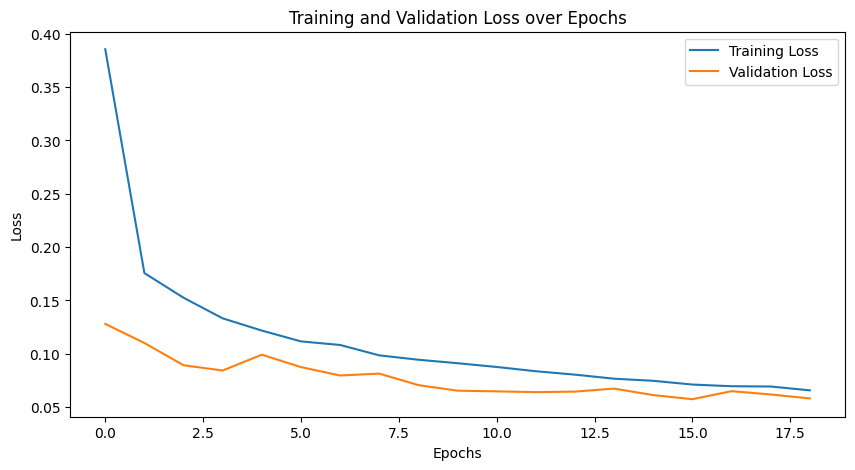

Validation Mean Loss: 0.05808690965096367 | Accuracy: 94.69999999999999%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.25; Optimizer SGD
Validation Mean Loss: 0.7269001555569629 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.8584, Accuracy: 20.46%
Validation Mean Loss: 0.5594739377030489 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 0.6403, Accuracy: 50.43%
Validation Mean Loss: 0.5555755372550537 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 0.6198, Accuracy: 50.79%
Validation Mean Loss: 0.5509452842147476 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 0.6151, Accuracy: 50.79%
Validation Mean Loss: 0.5496216326777977 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 0.6128, Accuracy: 50.78%
Validation Mean Loss: 0.548256423865554 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 0.6126, Accuracy: 50.79%
Validation Mean Loss: 0.541680

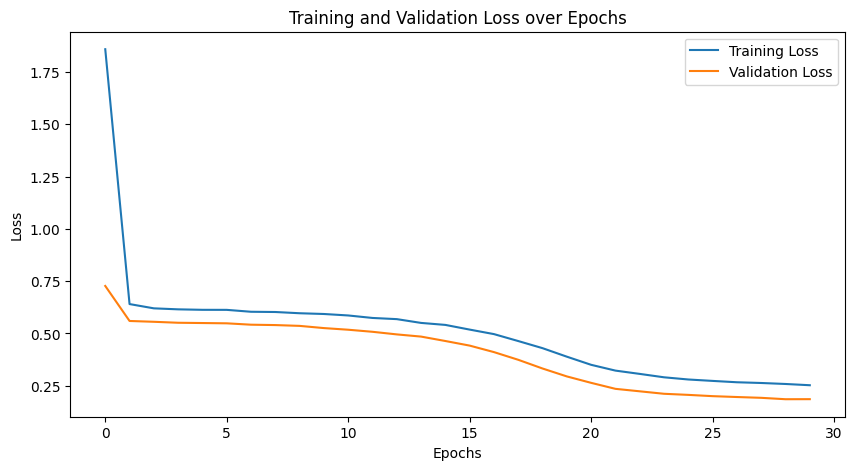

Validation Mean Loss: 0.18571980043928674 | Accuracy: 75.13333333333333%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.5; Optimizer Adam
Validation Mean Loss: 0.13630041812962673 | Accuracy: 83.16666666666667%
Epoch [1/30], Loss: 0.5416, Accuracy: 53.52%
Validation Mean Loss: 0.11613379743822078 | Accuracy: 86.3%
Epoch [2/30], Loss: 0.2790, Accuracy: 66.97%
Validation Mean Loss: 0.10005481711568985 | Accuracy: 88.73333333333333%
Epoch [3/30], Loss: 0.2281, Accuracy: 71.60%
Validation Mean Loss: 0.09849880705092182 | Accuracy: 89.46666666666667%
Epoch [4/30], Loss: 0.2013, Accuracy: 74.35%
Validation Mean Loss: 0.0850602877821694 | Accuracy: 92.0%
Epoch [5/30], Loss: 0.1811, Accuracy: 76.79%
Validation Mean Loss: 0.08238323615427981 | Accuracy: 92.2%
Epoch [6/30], Loss: 0.1597, Accuracy: 79.48%
Validation Mean Loss: 0.0860109185364018 | Accuracy: 91.3333333333333

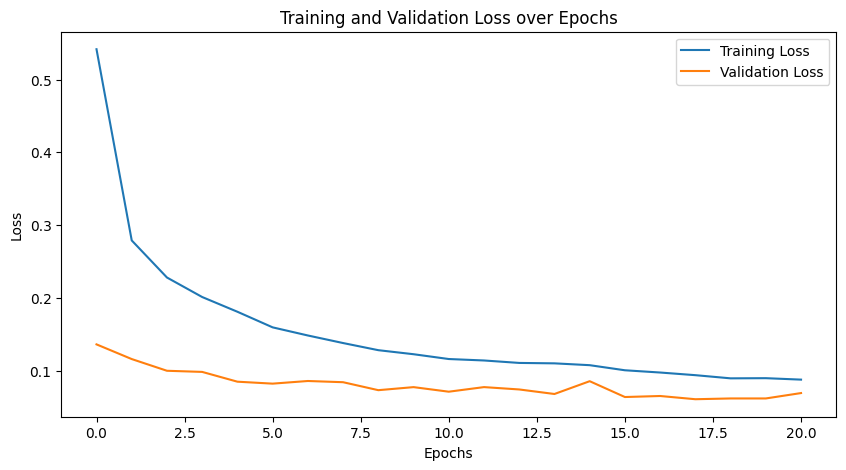

Validation Mean Loss: 0.0694401938210618 | Accuracy: 92.26666666666667%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.5; Optimizer SGD
Validation Mean Loss: 0.5651466245663926 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.9477, Accuracy: 23.31%
Validation Mean Loss: 0.5426888539495461 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 0.7001, Accuracy: 46.48%
Validation Mean Loss: 0.5343641323195969 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 0.6711, Accuracy: 48.10%
Validation Mean Loss: 0.5267141883340763 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 0.6422, Accuracy: 48.39%
Validation Mean Loss: 0.5170678524473841 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 0.6352, Accuracy: 49.07%
Validation Mean Loss: 0.4986585814337385 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 0.6144, Accuracy: 49.63%
Validation Mean Loss: 0.4819625

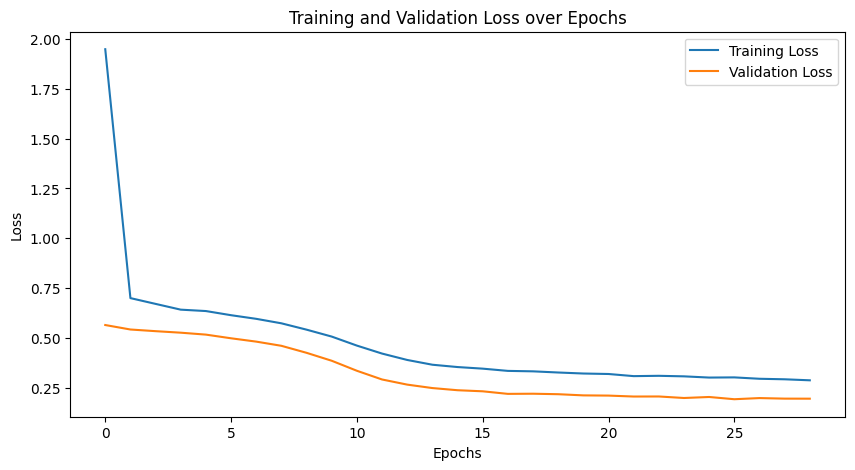

Validation Mean Loss: 0.1959446668624878 | Accuracy: 76.66666666666667%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation relu; Pooling type max; Dropout rate 0.25; Optimizer Adam
Validation Mean Loss: 0.07721673084938145 | Accuracy: 92.83333333333333%
Epoch [1/30], Loss: 0.3233, Accuracy: 68.56%
Validation Mean Loss: 0.06152390511310164 | Accuracy: 95.3%
Epoch [2/30], Loss: 0.1446, Accuracy: 82.01%
Validation Mean Loss: 0.05092617740577206 | Accuracy: 96.43333333333334%
Epoch [3/30], Loss: 0.1216, Accuracy: 85.58%
Validation Mean Loss: 0.03892621408870563 | Accuracy: 98.33333333333333%
Epoch [4/30], Loss: 0.1056, Accuracy: 87.94%
Validation Mean Loss: 0.04499042419558193 | Accuracy: 97.13333333333334%
Epoch [5/30], Loss: 0.0896, Accuracy: 90.64%
Validation Mean Loss: 0.024385938009722753 | Accuracy: 99.53333333333333%
Epoch [6/30], Loss: 0.0774, Accuracy: 92.62%
Validation Mean Loss: 0.02341708214566523 | Acc

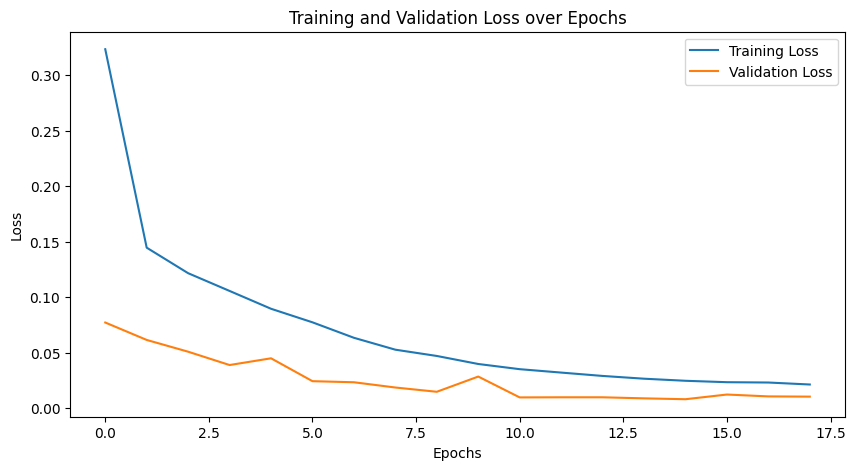

Validation Mean Loss: 0.010466682538575928 | Accuracy: 99.63333333333333%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation relu; Pooling type max; Dropout rate 0.25; Optimizer SGD
Validation Mean Loss: 0.5222800249342826 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.6024, Accuracy: 31.94%
Validation Mean Loss: 0.502564148085707 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 0.6417, Accuracy: 48.72%
Validation Mean Loss: 0.4861365349943492 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 0.6021, Accuracy: 49.98%
Validation Mean Loss: 0.4315599934619039 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 0.5589, Accuracy: 50.93%
Validation Mean Loss: 0.3646511247312214 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 0.5072, Accuracy: 52.53%
Validation Mean Loss: 0.2682407119291577 | Accuracy: 60.0%
Epoch [6/30], Loss: 0.4202, Accuracy: 56.29%
Validation Mean Loss: 0.18640079297759432 | Accur

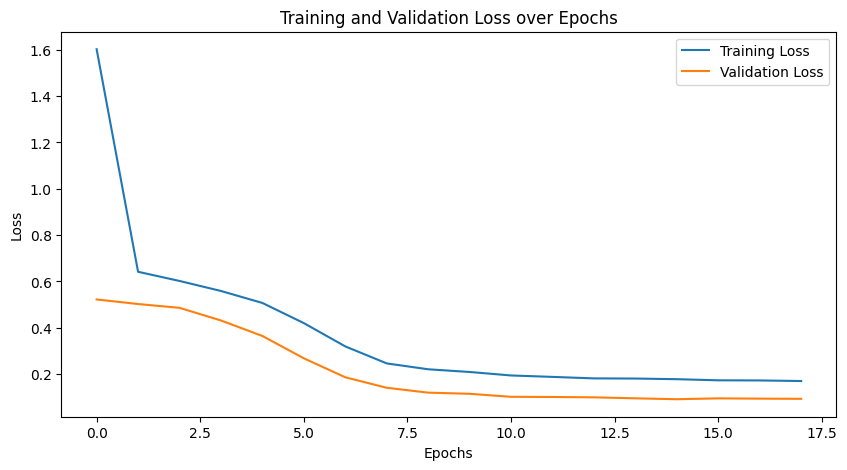

Validation Mean Loss: 0.0933821688386354 | Accuracy: 89.23333333333333%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation relu; Pooling type max; Dropout rate 0.5; Optimizer Adam
Validation Mean Loss: 0.08773196141849807 | Accuracy: 91.86666666666666%
Epoch [1/30], Loss: 0.5100, Accuracy: 55.12%
Validation Mean Loss: 0.12124832722536744 | Accuracy: 86.26666666666667%
Epoch [2/30], Loss: 0.2629, Accuracy: 67.90%
Validation Mean Loss: 0.047829564066326366 | Accuracy: 97.46666666666667%
Epoch [3/30], Loss: 0.2139, Accuracy: 73.90%
Validation Mean Loss: 0.04654571368418475 | Accuracy: 97.26666666666667%
Epoch [4/30], Loss: 0.1759, Accuracy: 78.54%
Validation Mean Loss: 0.040301974724106335 | Accuracy: 98.0%
Epoch [5/30], Loss: 0.1501, Accuracy: 82.15%
Validation Mean Loss: 0.03827716766836795 | Accuracy: 98.13333333333333%
Epoch [6/30], Loss: 0.1259, Accuracy: 85.47%
Validation Mean Loss: 0.0470091210767389 | Accu

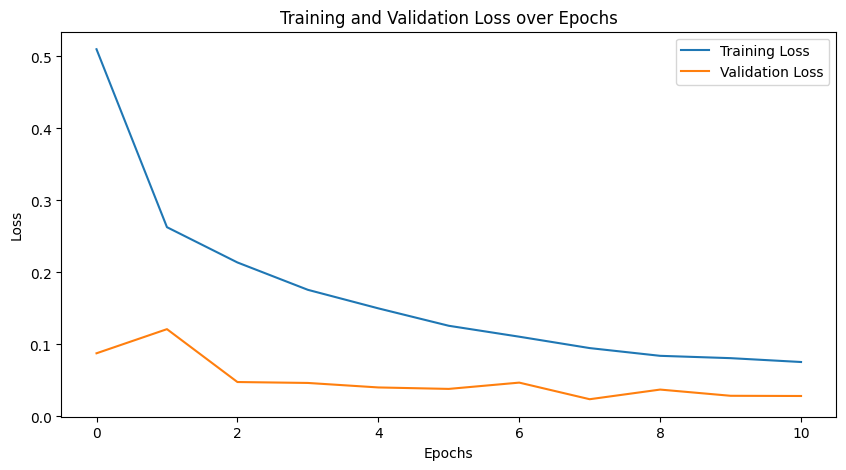

Validation Mean Loss: 0.028427717259817537 | Accuracy: 98.83333333333333%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation relu; Pooling type max; Dropout rate 0.5; Optimizer SGD
Validation Mean Loss: 0.5663890883009485 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.4017, Accuracy: 32.63%
Validation Mean Loss: 0.5321957842308156 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 0.7522, Accuracy: 43.50%
Validation Mean Loss: 0.5329874623368712 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 0.7036, Accuracy: 45.43%
Validation Mean Loss: 0.5114752023005263 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 0.6613, Accuracy: 47.06%
Validation Mean Loss: 0.48348038531641696 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 0.6269, Accuracy: 48.34%
Validation Mean Loss: 0.45196231650783025 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 0.5880, Accuracy: 49.60%
Validation Mean Loss: 0.393231730

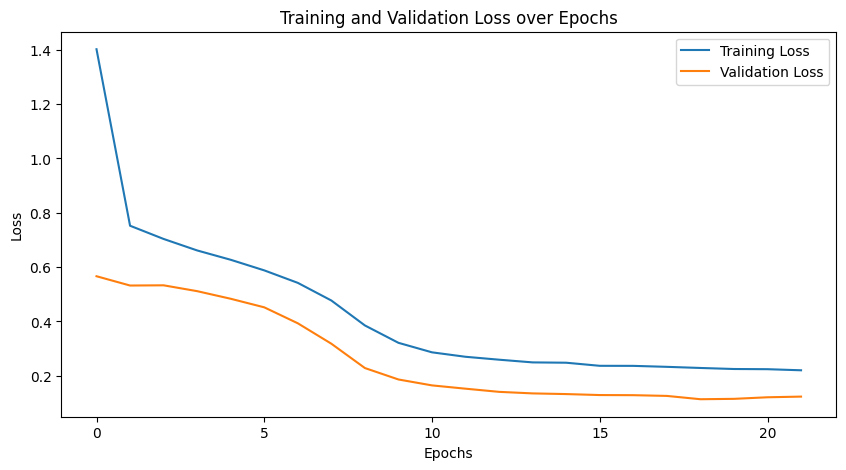

Validation Mean Loss: 0.12346902933526546 | Accuracy: 87.8%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.25; Optimizer Adam
Validation Mean Loss: 0.0829114618889512 | Accuracy: 92.66666666666666%
Epoch [1/30], Loss: 0.3047, Accuracy: 69.17%
Validation Mean Loss: 0.06663062393744575 | Accuracy: 95.39999999999999%
Epoch [2/30], Loss: 0.1460, Accuracy: 82.19%
Validation Mean Loss: 0.05603771887600739 | Accuracy: 95.93333333333334%
Epoch [3/30], Loss: 0.1238, Accuracy: 85.33%
Validation Mean Loss: 0.04502476355899373 | Accuracy: 96.89999999999999%
Epoch [4/30], Loss: 0.1014, Accuracy: 88.69%
Validation Mean Loss: 0.03260581945861749 | Accuracy: 98.8%
Epoch [5/30], Loss: 0.0818, Accuracy: 91.62%
Validation Mean Loss: 0.03147634901069204 | Accuracy: 98.73333333333333%
Epoch [6/30], Loss: 0.0668, Accuracy: 94.34%
Validation Mean Loss: 0.02496468668067927 | Accuracy: 9

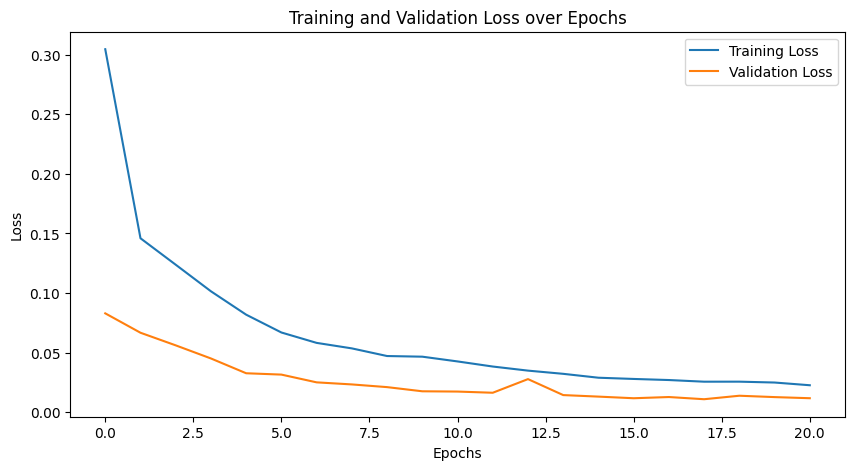

Validation Mean Loss: 0.011643269320979635 | Accuracy: 99.66666666666667%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.25; Optimizer SGD
Validation Mean Loss: 0.5449864905026612 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.3062, Accuracy: 37.43%
Validation Mean Loss: 0.5478566340715724 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 0.6666, Accuracy: 48.33%
Validation Mean Loss: 0.5305750700124995 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 0.6532, Accuracy: 49.04%
Validation Mean Loss: 0.5240751070049691 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 0.6368, Accuracy: 49.62%
Validation Mean Loss: 0.5033676266779211 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 0.6087, Accuracy: 49.71%
Validation Mean Loss: 0.4732544144102808 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 0.5904, Accuracy: 50.33%
Validation Mean Loss: 0.4341

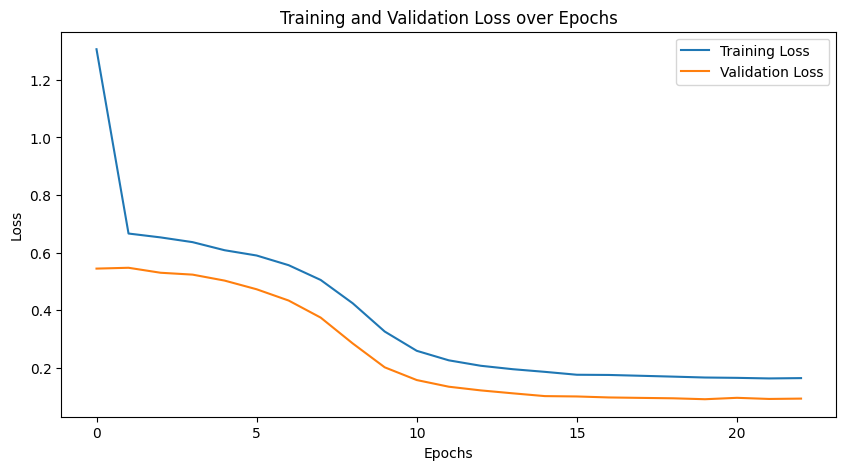

Validation Mean Loss: 0.09390549478616486 | Accuracy: 88.43333333333334%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.5; Optimizer Adam
Validation Mean Loss: 0.1070723266122823 | Accuracy: 88.33333333333333%
Epoch [1/30], Loss: 0.4239, Accuracy: 59.12%
Validation Mean Loss: 0.1439313871706737 | Accuracy: 80.46666666666667%
Epoch [2/30], Loss: 0.2272, Accuracy: 72.01%
Validation Mean Loss: 0.061669119930964834 | Accuracy: 95.26666666666667%
Epoch [3/30], Loss: 0.1778, Accuracy: 77.92%
Validation Mean Loss: 0.04883585901970559 | Accuracy: 97.03333333333333%
Epoch [4/30], Loss: 0.1531, Accuracy: 80.82%
Validation Mean Loss: 0.03315597023577132 | Accuracy: 98.76666666666667%
Epoch [5/30], Loss: 0.1277, Accuracy: 84.94%
Validation Mean Loss: 0.028899294601634463 | Accuracy: 99.23333333333333%
Epoch [6/30], Loss: 0.1065, Accuracy: 88.18%
Validation Mean Loss: 0.02864

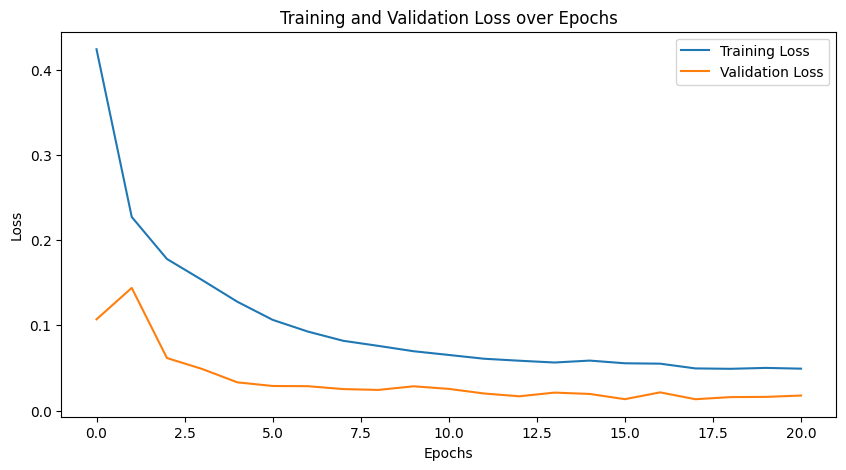

Validation Mean Loss: 0.017684127142197116 | Accuracy: 99.53333333333333%
Learning rate 0.001; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.5; Optimizer SGD
Validation Mean Loss: 0.5748430472065477 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 1.4316, Accuracy: 31.43%
Validation Mean Loss: 0.5466200620322389 | Accuracy: 53.333333333333336%
Epoch [2/30], Loss: 0.7745, Accuracy: 42.94%
Validation Mean Loss: 0.5625870622139661 | Accuracy: 53.333333333333336%
Epoch [3/30], Loss: 0.7301, Accuracy: 45.11%
Validation Mean Loss: 0.535026059961541 | Accuracy: 53.333333333333336%
Epoch [4/30], Loss: 0.6840, Accuracy: 46.85%
Validation Mean Loss: 0.5172839673196382 | Accuracy: 53.333333333333336%
Epoch [5/30], Loss: 0.6568, Accuracy: 47.77%
Validation Mean Loss: 0.47687073726642953 | Accuracy: 53.333333333333336%
Epoch [6/30], Loss: 0.6187, Accuracy: 49.00%
Validation Mean Loss: 0.41871

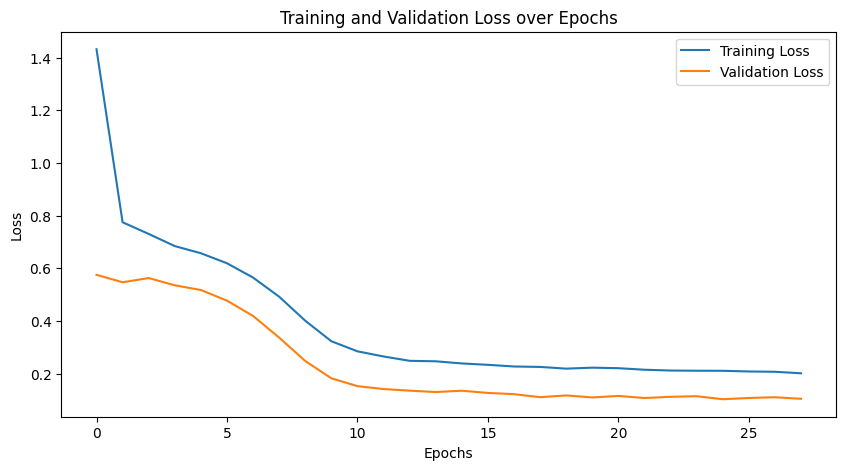

Validation Mean Loss: 0.104103850715972 | Accuracy: 90.53333333333333%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation relu; Pooling type max; Dropout rate 0.25; Optimizer Adam
Validation Mean Loss: 0.11173564306599029 | Accuracy: 87.03333333333333%
Epoch [1/30], Loss: 0.2770, Accuracy: 68.17%
Validation Mean Loss: 0.08640073605892347 | Accuracy: 90.56666666666666%
Epoch [2/30], Loss: 0.1608, Accuracy: 79.47%
Validation Mean Loss: 0.10367483487154575 | Accuracy: 87.4%
Epoch [3/30], Loss: 0.1278, Accuracy: 83.50%
Validation Mean Loss: 0.07268826718977157 | Accuracy: 92.46666666666667%
Epoch [4/30], Loss: 0.1139, Accuracy: 85.63%
Validation Mean Loss: 0.10554110455485259 | Accuracy: 85.93333333333332%
Epoch [5/30], Loss: 0.1124, Accuracy: 86.21%
Validation Mean Loss: 0.10406695846270056 | Accuracy: 85.23333333333333%
Epoch [6/30], Loss: 0.1138, Accuracy: 86.13%
Validation Mean Loss: 0.0778247740397111 | Accurac

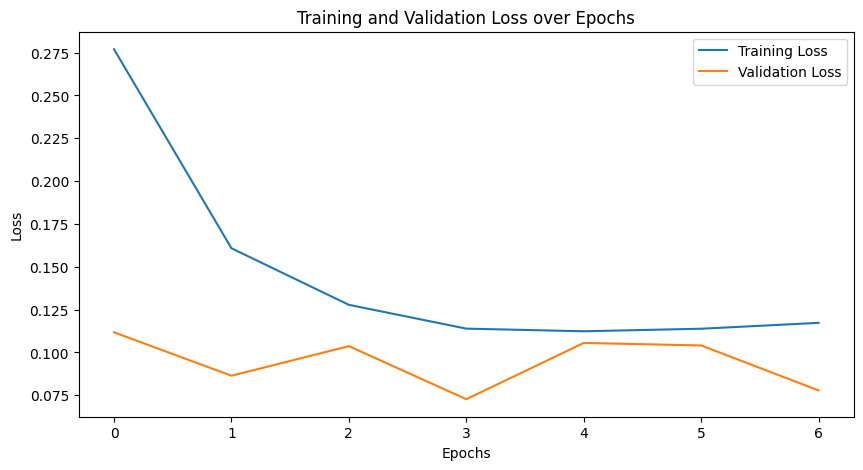

Validation Mean Loss: 0.0778247740397111 | Accuracy: 91.33333333333333%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation relu; Pooling type max; Dropout rate 0.25; Optimizer SGD
Validation Mean Loss: 0.21394480416115294 | Accuracy: 73.13333333333333%
Epoch [1/30], Loss: 0.5713, Accuracy: 52.34%
Validation Mean Loss: 0.16286304985430647 | Accuracy: 78.5%
Epoch [2/30], Loss: 0.2546, Accuracy: 65.30%
Validation Mean Loss: 0.14862772077322006 | Accuracy: 80.33333333333333%
Epoch [3/30], Loss: 0.2209, Accuracy: 69.20%
Validation Mean Loss: 0.1430189784299186 | Accuracy: 80.30000000000001%
Epoch [4/30], Loss: 0.2014, Accuracy: 71.65%
Validation Mean Loss: 0.1320085865544512 | Accuracy: 82.33333333333334%
Epoch [5/30], Loss: 0.1835, Accuracy: 74.30%
Validation Mean Loss: 0.13160295047341508 | Accuracy: 81.56666666666666%
Epoch [6/30], Loss: 0.1764, Accuracy: 75.47%
Validation Mean Loss: 0.12123458059702782 | Accuracy

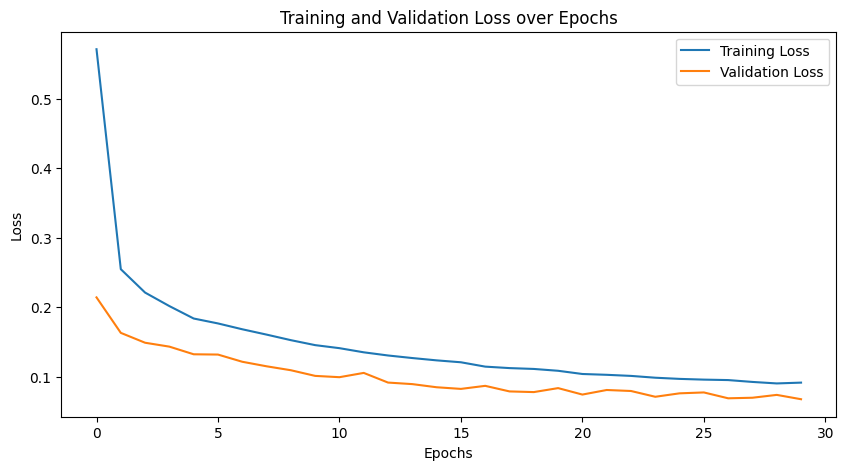

Validation Mean Loss: 0.06729070077392649 | Accuracy: 93.7%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation relu; Pooling type max; Dropout rate 0.5; Optimizer Adam
Validation Mean Loss: 0.16097169611206713 | Accuracy: 79.93333333333334%
Epoch [1/30], Loss: 0.4287, Accuracy: 58.67%
Validation Mean Loss: 0.08636472106693273 | Accuracy: 90.93333333333334%
Epoch [2/30], Loss: 0.2172, Accuracy: 72.83%
Validation Mean Loss: 0.0865993700683751 | Accuracy: 90.56666666666666%
Epoch [3/30], Loss: 0.1790, Accuracy: 77.64%
Validation Mean Loss: 0.09052119188089953 | Accuracy: 88.23333333333333%
Epoch [4/30], Loss: 0.1781, Accuracy: 77.90%
Validation Mean Loss: 0.09593004553004149 | Accuracy: 86.83333333333333%
Epoch [5/30], Loss: 0.1664, Accuracy: 79.51%
Early stopping done


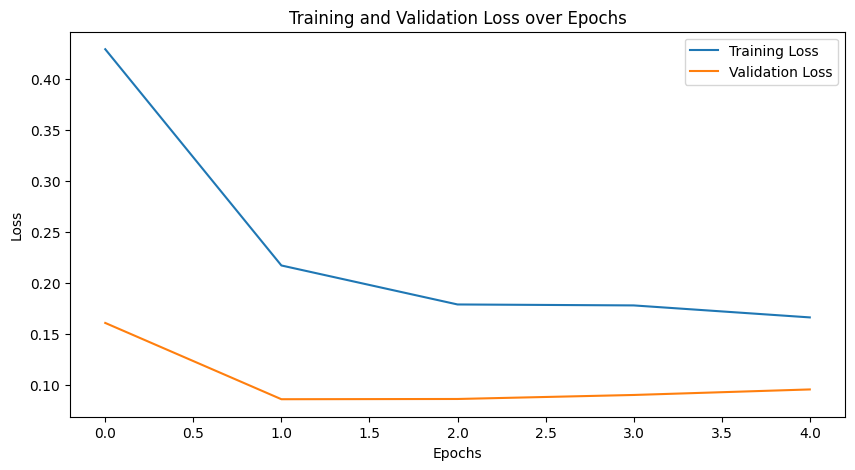

Validation Mean Loss: 0.09593004553004149 | Accuracy: 86.83333333333333%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation relu; Pooling type max; Dropout rate 0.5; Optimizer SGD
Validation Mean Loss: 0.534025933187606 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 0.8120, Accuracy: 46.26%
Validation Mean Loss: 0.29586722083548284 | Accuracy: 60.06666666666667%
Epoch [2/30], Loss: 0.5358, Accuracy: 51.91%
Validation Mean Loss: 0.20863468968804846 | Accuracy: 75.16666666666667%
Epoch [3/30], Loss: 0.3442, Accuracy: 60.56%
Validation Mean Loss: 0.1903893529100621 | Accuracy: 77.46666666666667%
Epoch [4/30], Loss: 0.2973, Accuracy: 64.62%
Validation Mean Loss: 0.1688734159032081 | Accuracy: 79.9%
Epoch [5/30], Loss: 0.2679, Accuracy: 67.87%
Validation Mean Loss: 0.15563690646531733 | Accuracy: 81.03333333333333%
Epoch [6/30], Loss: 0.2473, Accuracy: 69.75%
Validation Mean Loss: 0.1399966688390742 | Accuracy: 

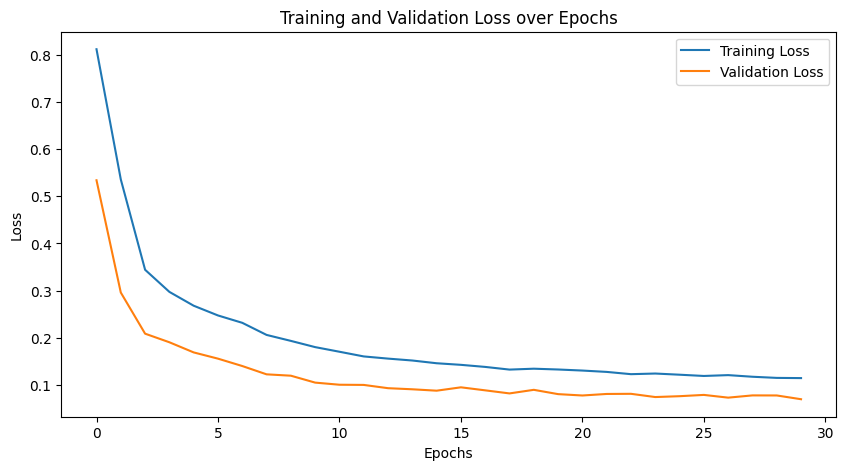

Validation Mean Loss: 0.06958452089035765 | Accuracy: 92.66666666666666%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.25; Optimizer Adam
Validation Mean Loss: 0.11831450212667598 | Accuracy: 85.3%
Epoch [1/30], Loss: 0.2873, Accuracy: 67.66%
Validation Mean Loss: 0.13018139835541195 | Accuracy: 83.26666666666667%
Epoch [2/30], Loss: 0.1368, Accuracy: 82.51%
Validation Mean Loss: 0.09654706421288405 | Accuracy: 90.53333333333333%
Epoch [3/30], Loss: 0.1156, Accuracy: 85.65%
Validation Mean Loss: 0.09630697018447075 | Accuracy: 89.2%
Epoch [4/30], Loss: 0.1420, Accuracy: 82.64%
Validation Mean Loss: 0.0758280190540121 | Accuracy: 92.03333333333333%
Epoch [5/30], Loss: 0.1120, Accuracy: 86.48%
Validation Mean Loss: 0.08530938783858685 | Accuracy: 90.2%
Epoch [6/30], Loss: 0.1095, Accuracy: 86.52%
Validation Mean Loss: 0.07407277224070215 | Accuracy: 92.5%
Epoch [7/

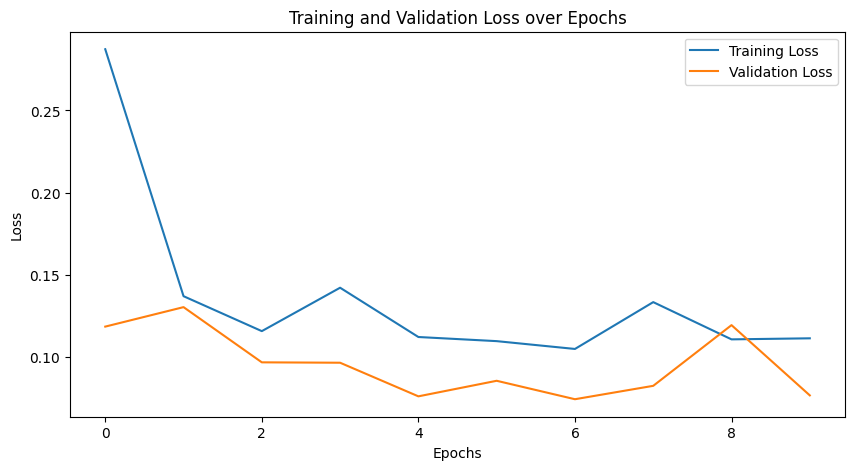

Validation Mean Loss: 0.0764151272671099 | Accuracy: 91.60000000000001%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.25; Optimizer SGD
Validation Mean Loss: 0.3746153794407369 | Accuracy: 53.86666666666666%
Epoch [1/30], Loss: 0.7173, Accuracy: 48.10%
Validation Mean Loss: 0.18425432767005676 | Accuracy: 74.76666666666667%
Epoch [2/30], Loss: 0.3207, Accuracy: 61.13%
Validation Mean Loss: 0.16238753117145377 | Accuracy: 78.23333333333333%
Epoch [3/30], Loss: 0.2403, Accuracy: 67.54%
Validation Mean Loss: 0.15272796498809724 | Accuracy: 78.8%
Epoch [4/30], Loss: 0.2214, Accuracy: 69.37%
Validation Mean Loss: 0.15206655681608838 | Accuracy: 79.3%
Epoch [5/30], Loss: 0.2052, Accuracy: 71.25%
Validation Mean Loss: 0.13478984382558376 | Accuracy: 81.56666666666666%
Epoch [6/30], Loss: 0.1946, Accuracy: 73.34%
Validation Mean Loss: 0.13076705933409802 | Accuracy: 82.2

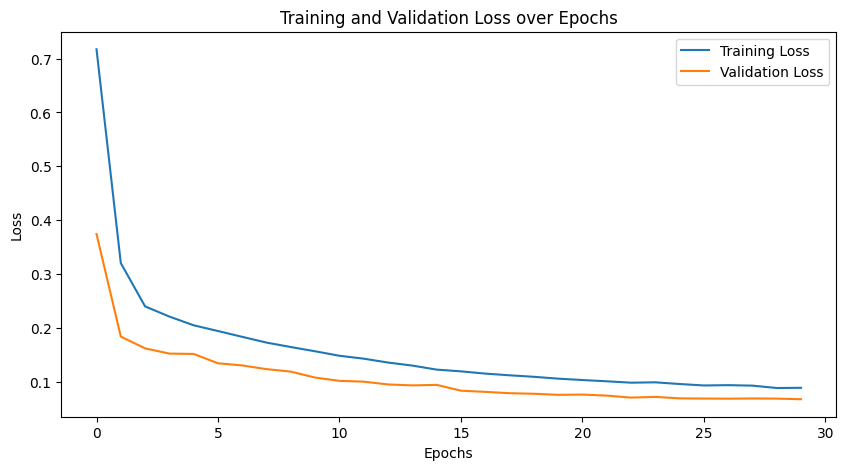

Validation Mean Loss: 0.06809759205405383 | Accuracy: 93.60000000000001%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.5; Optimizer Adam
Validation Mean Loss: 0.12453192841023841 | Accuracy: 84.56666666666666%
Epoch [1/30], Loss: 0.4606, Accuracy: 59.09%
Validation Mean Loss: 0.17466504536965427 | Accuracy: 74.36666666666667%
Epoch [2/30], Loss: 0.2062, Accuracy: 73.42%
Validation Mean Loss: 0.19920237172157207 | Accuracy: 72.6%
Epoch [3/30], Loss: 0.4488, Accuracy: 57.83%
Validation Mean Loss: 0.14749791227439615 | Accuracy: 78.73333333333333%
Epoch [4/30], Loss: 0.2260, Accuracy: 69.35%
Early stopping done


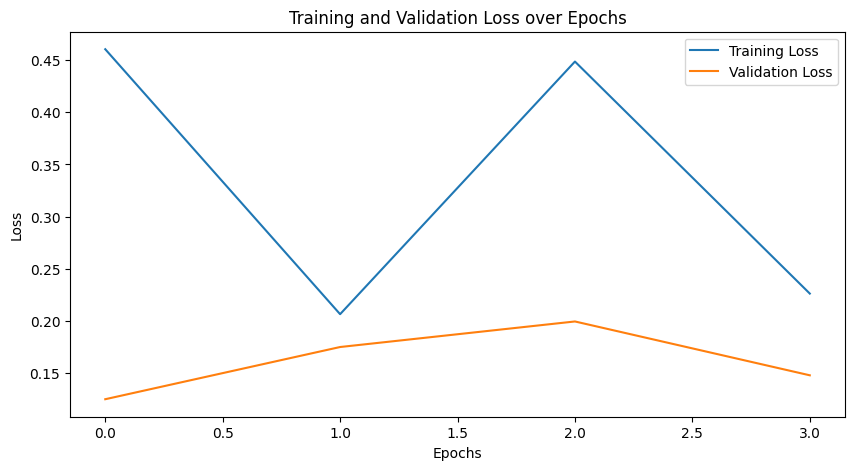

Validation Mean Loss: 0.14749791227439615 | Accuracy: 78.73333333333333%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 3; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.5; Optimizer SGD
Validation Mean Loss: 0.5455741635808582 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 0.8060, Accuracy: 46.53%
Validation Mean Loss: 0.3878809410008661 | Accuracy: 53.300000000000004%
Epoch [2/30], Loss: 0.5709, Accuracy: 51.18%
Validation Mean Loss: 0.2190215316937959 | Accuracy: 73.63333333333333%
Epoch [3/30], Loss: 0.3620, Accuracy: 59.56%
Validation Mean Loss: 0.21343108868979394 | Accuracy: 74.13333333333333%
Epoch [4/30], Loss: 0.2961, Accuracy: 64.10%
Validation Mean Loss: 0.17796731411301075 | Accuracy: 78.5%
Epoch [5/30], Loss: 0.2719, Accuracy: 66.89%
Validation Mean Loss: 0.15018345990238038 | Accuracy: 81.69999999999999%
Epoch [6/30], Loss: 0.2479, Accuracy: 69.44%
Validation Mean Loss: 0.1376160401058324 | Ac

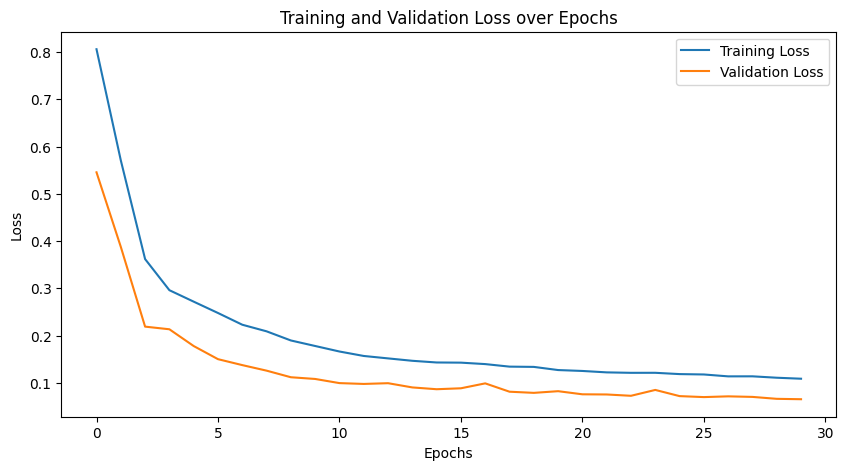

Validation Mean Loss: 0.06541535892385117 | Accuracy: 93.60000000000001%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation relu; Pooling type max; Dropout rate 0.25; Optimizer Adam
Validation Mean Loss: 0.08144285252436678 | Accuracy: 90.0%
Epoch [1/30], Loss: 0.4622, Accuracy: 63.69%
Validation Mean Loss: 0.02386735162783583 | Accuracy: 99.2%
Epoch [2/30], Loss: 0.1094, Accuracy: 87.45%
Validation Mean Loss: 0.021744601312093437 | Accuracy: 99.0%
Epoch [3/30], Loss: 0.0687, Accuracy: 93.05%
Validation Mean Loss: 0.016904663264830696 | Accuracy: 99.06666666666666%
Epoch [4/30], Loss: 0.0503, Accuracy: 95.10%
Validation Mean Loss: 0.022861119201208684 | Accuracy: 99.23333333333333%
Epoch [5/30], Loss: 0.0431, Accuracy: 96.17%
Validation Mean Loss: 0.01467585165494498 | Accuracy: 99.33333333333333%
Epoch [6/30], Loss: 0.0392, Accuracy: 96.88%
Validation Mean Loss: 0.01580073641788987 | Accuracy: 99.53333333333333

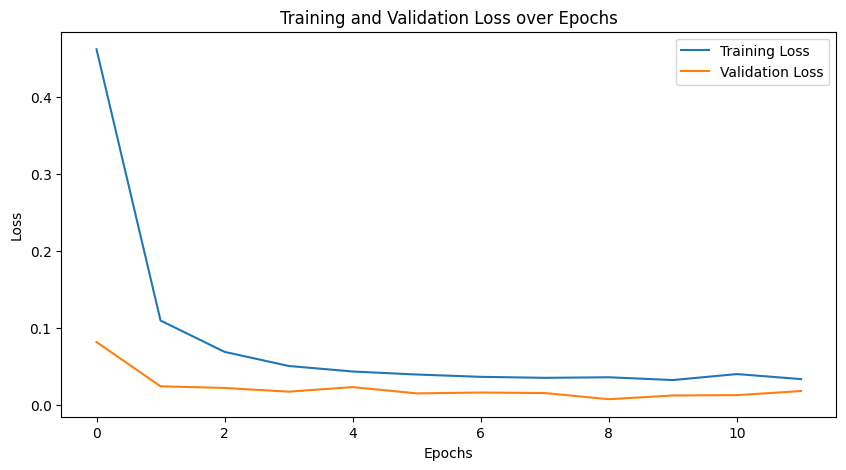

Validation Mean Loss: 0.017703628530504847 | Accuracy: 99.16666666666667%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation relu; Pooling type max; Dropout rate 0.25; Optimizer SGD
Validation Mean Loss: 0.11333465255162817 | Accuracy: 86.93333333333332%
Epoch [1/30], Loss: 0.4659, Accuracy: 57.95%
Validation Mean Loss: 0.10366209853995353 | Accuracy: 87.16666666666667%
Epoch [2/30], Loss: 0.1803, Accuracy: 75.06%
Validation Mean Loss: 0.08991854639842789 | Accuracy: 88.96666666666667%
Epoch [3/30], Loss: 0.1624, Accuracy: 77.67%
Validation Mean Loss: 0.08037009672757159 | Accuracy: 90.8%
Epoch [4/30], Loss: 0.1499, Accuracy: 79.49%
Validation Mean Loss: 0.0775819510578158 | Accuracy: 90.66666666666666%
Epoch [5/30], Loss: 0.1381, Accuracy: 80.90%
Validation Mean Loss: 0.0656750503273562 | Accuracy: 92.56666666666666%
Epoch [6/30], Loss: 0.1233, Accuracy: 83.37%
Validation Mean Loss: 0.07303509112209716 | Accura

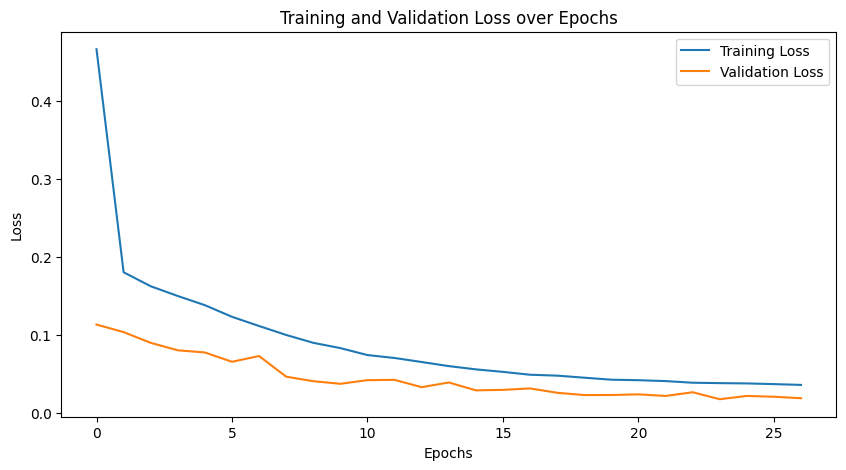

Validation Mean Loss: 0.018991667144446375 | Accuracy: 99.5%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation relu; Pooling type max; Dropout rate 0.5; Optimizer Adam
Validation Mean Loss: 0.0537496122749562 | Accuracy: 96.23333333333333%
Epoch [1/30], Loss: 0.4535, Accuracy: 61.66%
Validation Mean Loss: 0.03584932358043783 | Accuracy: 97.83333333333334%
Epoch [2/30], Loss: 0.1470, Accuracy: 82.50%
Validation Mean Loss: 0.035986473508912355 | Accuracy: 94.63333333333334%
Epoch [3/30], Loss: 0.1134, Accuracy: 86.80%
Validation Mean Loss: 0.026483752846499866 | Accuracy: 98.83333333333333%
Epoch [4/30], Loss: 0.0970, Accuracy: 88.88%
Validation Mean Loss: 0.04011450186272726 | Accuracy: 97.16666666666667%
Epoch [5/30], Loss: 0.0900, Accuracy: 89.87%
Validation Mean Loss: 0.022596712219231624 | Accuracy: 99.0%
Epoch [6/30], Loss: 0.0940, Accuracy: 89.87%
Validation Mean Loss: 0.01932207352055752 | Accuracy: 99.43

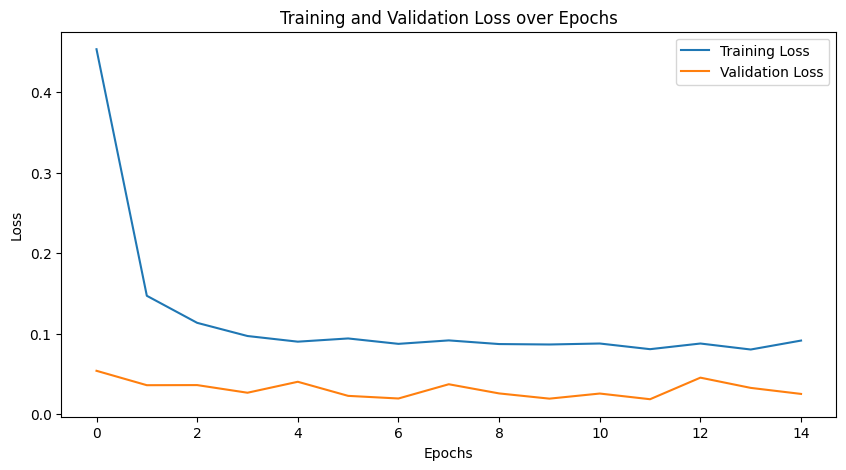

Validation Mean Loss: 0.02500625421352526 | Accuracy: 99.43333333333332%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation relu; Pooling type max; Dropout rate 0.5; Optimizer SGD
Validation Mean Loss: 0.15396138930574377 | Accuracy: 83.43333333333334%
Epoch [1/30], Loss: 0.5946, Accuracy: 52.04%
Validation Mean Loss: 0.1423920060289984 | Accuracy: 84.1%
Epoch [2/30], Loss: 0.2361, Accuracy: 71.17%
Validation Mean Loss: 0.10480751503417467 | Accuracy: 89.56666666666668%
Epoch [3/30], Loss: 0.2095, Accuracy: 74.68%
Validation Mean Loss: 0.09513594749126028 | Accuracy: 90.66666666666666%
Epoch [4/30], Loss: 0.1930, Accuracy: 76.42%
Validation Mean Loss: 0.08161979195404243 | Accuracy: 92.30000000000001%
Epoch [5/30], Loss: 0.1776, Accuracy: 78.64%
Validation Mean Loss: 0.06615358630710459 | Accuracy: 94.6%
Epoch [6/30], Loss: 0.1597, Accuracy: 79.97%
Validation Mean Loss: 0.06531378049205275 | Accuracy: 92.9%
Epoc

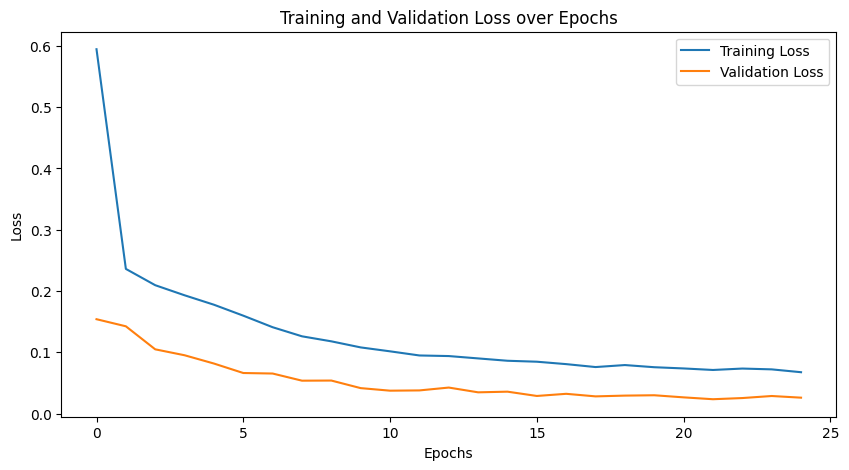

Validation Mean Loss: 0.025921115210834653 | Accuracy: 99.3%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.25; Optimizer Adam
Validation Mean Loss: 0.3594627145558913 | Accuracy: 67.80000000000001%
Epoch [1/30], Loss: 0.5699, Accuracy: 70.53%
Validation Mean Loss: 0.059746734243124086 | Accuracy: 97.33333333333334%
Epoch [2/30], Loss: 0.1752, Accuracy: 78.19%
Validation Mean Loss: 0.05088850572467484 | Accuracy: 97.76666666666667%
Epoch [3/30], Loss: 0.1302, Accuracy: 84.98%
Validation Mean Loss: 0.045763714635308754 | Accuracy: 97.96666666666667%
Epoch [4/30], Loss: 0.1079, Accuracy: 88.90%
Validation Mean Loss: 0.04615987351837945 | Accuracy: 98.06666666666666%
Epoch [5/30], Loss: 0.0953, Accuracy: 90.28%
Validation Mean Loss: 0.07498057725581717 | Accuracy: 93.10000000000001%
Epoch [6/30], Loss: 0.8431, Accuracy: 61.50%
Validation Mean Loss: 0.0531942138963557

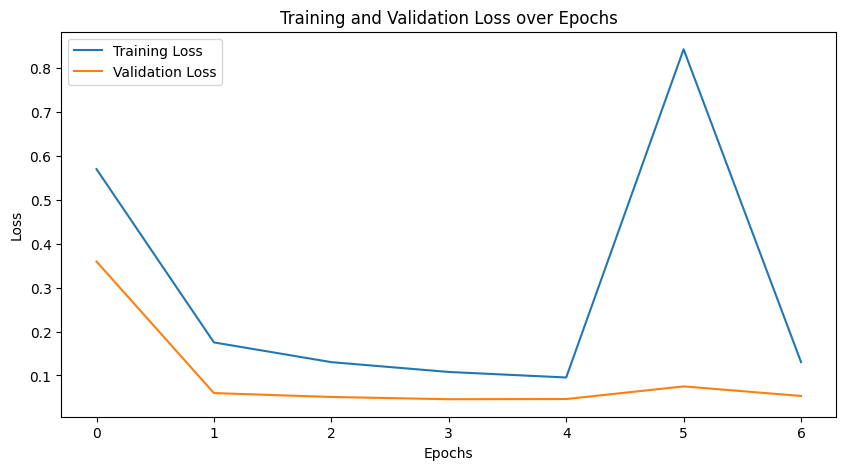

Validation Mean Loss: 0.05319421389635573 | Accuracy: 96.43333333333334%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.25; Optimizer SGD
Validation Mean Loss: 0.1084738165298675 | Accuracy: 88.26666666666667%
Epoch [1/30], Loss: 0.4791, Accuracy: 58.62%
Validation Mean Loss: 0.09296689998913318 | Accuracy: 89.43333333333334%
Epoch [2/30], Loss: 0.1820, Accuracy: 75.32%
Validation Mean Loss: 0.09064466799510286 | Accuracy: 89.13333333333333%
Epoch [3/30], Loss: 0.1644, Accuracy: 77.63%
Validation Mean Loss: 0.08134503608093933 | Accuracy: 90.26666666666667%
Epoch [4/30], Loss: 0.1493, Accuracy: 79.60%
Validation Mean Loss: 0.07715276820941809 | Accuracy: 90.56666666666666%
Epoch [5/30], Loss: 0.1354, Accuracy: 81.52%
Validation Mean Loss: 0.08050966298485056 | Accuracy: 90.0%
Epoch [6/30], Loss: 0.1244, Accuracy: 83.13%
Validation Mean Loss: 0.05623619603191284 | 

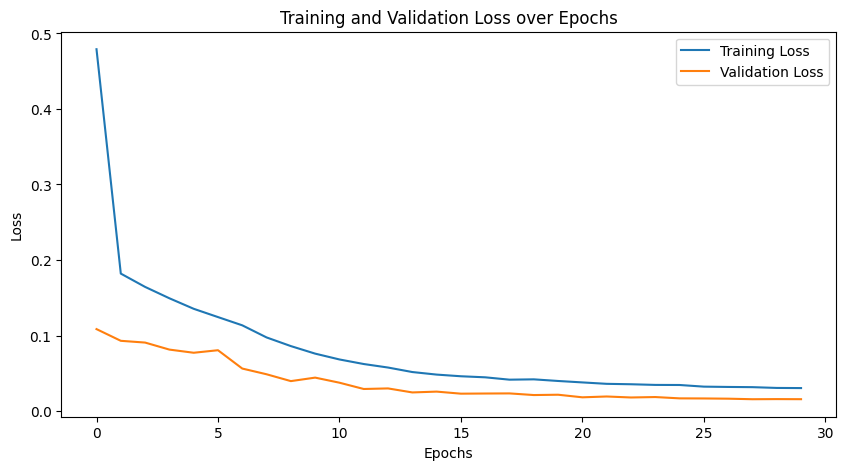

Validation Mean Loss: 0.015661554324980627 | Accuracy: 99.6%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.5; Optimizer Adam
Validation Mean Loss: 0.0772174874201734 | Accuracy: 93.83333333333333%
Epoch [1/30], Loss: 0.5172, Accuracy: 55.78%
Validation Mean Loss: 0.045279072379653756 | Accuracy: 97.33333333333334%
Epoch [2/30], Loss: 0.1522, Accuracy: 81.25%
Validation Mean Loss: 0.07684101193073264 | Accuracy: 90.03333333333333%
Epoch [3/30], Loss: 0.2505, Accuracy: 74.02%
Validation Mean Loss: 0.05288479194798051 | Accuracy: 94.83333333333334%
Epoch [4/30], Loss: 0.1320, Accuracy: 82.98%
Validation Mean Loss: 0.03508484872811018 | Accuracy: 98.9%
Epoch [5/30], Loss: 0.1500, Accuracy: 81.60%
Validation Mean Loss: 0.037839099502270206 | Accuracy: 95.8%
Epoch [6/30], Loss: 0.1135, Accuracy: 85.72%
Validation Mean Loss: 0.5566119535930177 | Accuracy: 53.33333333333

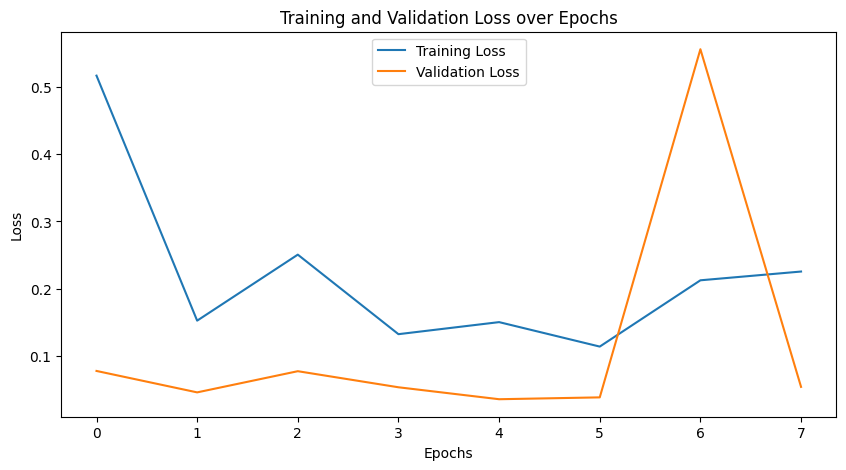

Validation Mean Loss: 0.05347985969460074 | Accuracy: 94.23333333333333%
Learning rate 0.01; Kernel size for conv layer 2; Kernel size for pool layer 2; Number of conv layers 2; Stride 2; Activation leaky_relu; Pooling type max; Dropout rate 0.5; Optimizer SGD
Validation Mean Loss: 0.5243691056570474 | Accuracy: 53.333333333333336%
Epoch [1/30], Loss: 0.8018, Accuracy: 45.27%
Validation Mean Loss: 0.14309197626611653 | Accuracy: 87.26666666666667%
Epoch [2/30], Loss: 0.3918, Accuracy: 59.70%
Validation Mean Loss: 0.12584664860859196 | Accuracy: 88.6%
Epoch [3/30], Loss: 0.2300, Accuracy: 73.06%
Validation Mean Loss: 0.10979405784622785 | Accuracy: 89.5%
Epoch [4/30], Loss: 0.2073, Accuracy: 75.79%
Validation Mean Loss: 0.08947191950171551 | Accuracy: 91.76666666666667%
Epoch [5/30], Loss: 0.1898, Accuracy: 77.47%
Validation Mean Loss: 0.08502908083709314 | Accuracy: 91.26666666666667%
Epoch [6/30], Loss: 0.1750, Accuracy: 78.76%
Validation Mean Loss: 0.06733524325264102 | Accuracy: 92.

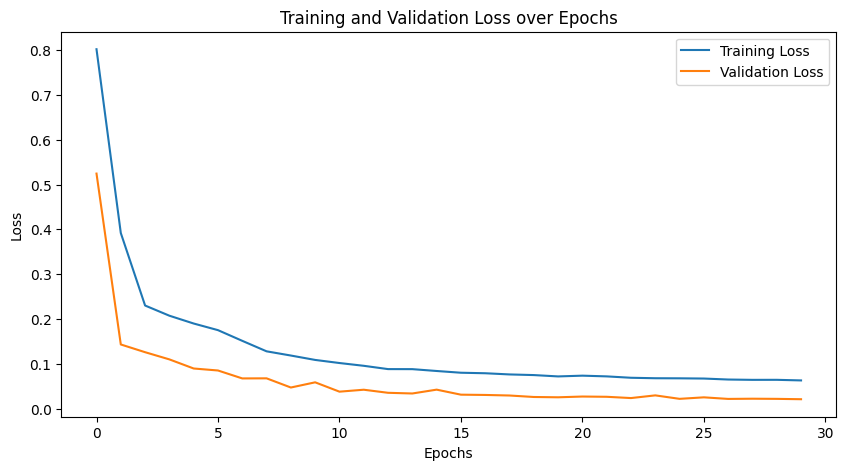

Validation Mean Loss: 0.020927783324720062 | Accuracy: 99.46666666666667%


In [8]:
best_parameters_reg = {'Learning rate' : 0.005, 
                   'Number of convolution layers':3, 
                   'Stride':2, 
                   'Activation':'relu', 
                   'Pooling type':'max', 
                   'Dropout Rate':0.25, 
                   'Optimizer':'Adam'}
best_val_accuracy_reg = float(-100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for lr in learning_rates:
    for conv_k in conv_kernel_sizes:
        for pool_k in pool_kernel_sizes:
            for n_layers in num_conv_layers:
                for stride in strides:
                    for activation in activations:
                        for pool_type in pooling_types:
                            for dropout in dropout_rates:
                                for opt in optimizers:
                                    print(f"Learning rate {lr}; Kernel size for conv layer {conv_k}; Kernel size for pool layer {pool_k}; Number of conv layers {n_layers}; Stride {stride}; Activation {activation}; Pooling type {pool_type}; Dropout rate {dropout}; Optimizer {opt}")
                                    model = CNN(optimizer = opt, activation=activation, task='regression', pool_type=pool_type,stride=stride,num_conv_layers=n_layers, conv_kernel_size=conv_k, pool_kernel_size=pool_k,num_classes=10, dropout_rate=dropout).to(device)
                                    model.train_model(train,val,learning_rate = lr)
                                    _, accuracy = model.evaluate_model(val)
                                    if accuracy > best_val_accuracy_reg:
                                        best_parameters_reg = {'Learning rate':lr,
                                                           'Number of convolution layers':n_layers,
                                                           'Stride':stride,
                                                           'Activation':activation,
                                                           'Pooling type':pool_type,
                                                           'Dropout Rate':dropout,
                                                           'Optimizer':opt}
                                        best_val_accuracy_reg = accuracy

In [9]:
print(f"Best validation accuracy achieved = {best_val_accuracy_reg}")
print("The best parameteres are\n",best_parameters_reg)

Best validation accuracy achieved = 99.66666666666667
The best parameteres are
 {'Learning rate': 0.001, 'Number of convolution layers': 2, 'Stride': 2, 'Activation': 'leaky_relu', 'Pooling type': 'max', 'Dropout Rate': 0.25, 'Optimizer': 'Adam'}


### Best parameters for regression (MSE Loss)
````Best validation accuracy achieved = 99.7%````
<br>

### The best parameteres are:

````'Learning rate': 0.001````
<br>
````'Number of convolution layers': 2````
<br>
````'Stride': 2````
<br>
````'Activation': 'leaky_relu'````
<br>
````'Pooling type': 'max'````
<br>
````'Dropout Rate': 0.25````
<br>
````'Optimizer': 'Adam'````

### Using the best parameters and running the model on the test set

Validation Mean Loss: 0.09077688379886936 | Accuracy: 90.76666666666667%
Epoch [1/30], Loss: 0.3864, Accuracy: 63.48%
Validation Mean Loss: 0.061765021733701866 | Accuracy: 95.89999999999999%
Epoch [2/30], Loss: 0.1703, Accuracy: 79.12%
Validation Mean Loss: 0.047030617542406346 | Accuracy: 97.76666666666667%
Epoch [3/30], Loss: 0.1327, Accuracy: 83.73%
Validation Mean Loss: 0.0482802036158899 | Accuracy: 97.26666666666667%
Epoch [4/30], Loss: 0.1037, Accuracy: 88.28%
Validation Mean Loss: 0.033058658222410275 | Accuracy: 99.16666666666667%
Epoch [5/30], Loss: 0.0878, Accuracy: 91.13%
Validation Mean Loss: 0.026839580763369165 | Accuracy: 99.43333333333332%
Epoch [6/30], Loss: 0.0763, Accuracy: 92.91%
Validation Mean Loss: 0.024450598527340495 | Accuracy: 99.43333333333332%
Epoch [7/30], Loss: 0.0678, Accuracy: 94.04%
Validation Mean Loss: 0.02114684396284692 | Accuracy: 99.63333333333333%
Epoch [8/30], Loss: 0.0618, Accuracy: 95.05%
Validation Mean Loss: 0.024196131115264082 | Accurac

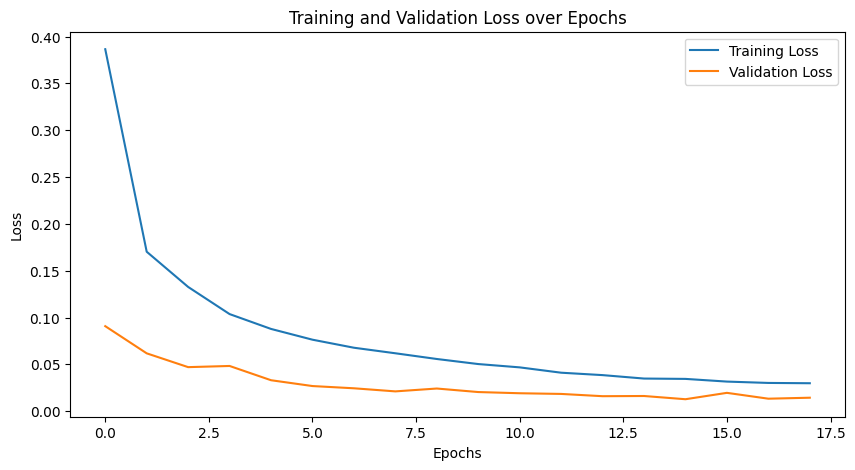

Validation Mean Loss: 0.01281540122646321 | Accuracy: 99.78260869565217%


In [40]:
model = CNN(optimizer = 'Adam', activation='leaky_relu', task='regression', pool_type='max',stride=2,num_conv_layers=2, conv_kernel_size=2, pool_kernel_size=2,num_classes=10, dropout_rate=0.25).to(device)
model.train_model(train,val,learning_rate = 0.001)
_, accuracy = model.evaluate_model(test)

In [41]:
print(f'Accuracy on Test data: {accuracy:.2f}%')

Accuracy on Test data: 99.78%


### Feature maps

#### Training the best classification model

Validation Mean Loss: 0.027169862666732058 | Accuracy: 99.13333333333333%
Epoch [1/30], Loss: 0.4349, Accuracy: 81.58%
Validation Mean Loss: 0.03972223656448013 | Accuracy: 98.66666666666667%
Epoch [2/30], Loss: 0.0609, Accuracy: 98.17%
Validation Mean Loss: 0.005476700495916142 | Accuracy: 99.76666666666667%
Epoch [3/30], Loss: 0.0396, Accuracy: 98.78%
Validation Mean Loss: 0.019830140427759633 | Accuracy: 99.2%
Epoch [4/30], Loss: 0.0295, Accuracy: 99.21%
Validation Mean Loss: 0.004730891364130351 | Accuracy: 99.83333333333333%
Epoch [5/30], Loss: 0.0212, Accuracy: 99.40%
Validation Mean Loss: 0.0037837461621987064 | Accuracy: 99.86666666666667%
Epoch [6/30], Loss: 0.0228, Accuracy: 99.26%
Validation Mean Loss: 0.002554390688582896 | Accuracy: 99.93333333333332%
Epoch [7/30], Loss: 0.0155, Accuracy: 99.55%
Validation Mean Loss: 0.017881320525721594 | Accuracy: 99.33333333333333%
Epoch [8/30], Loss: 0.0163, Accuracy: 99.48%
Validation Mean Loss: 0.01873460789526081 | Accuracy: 99.6666

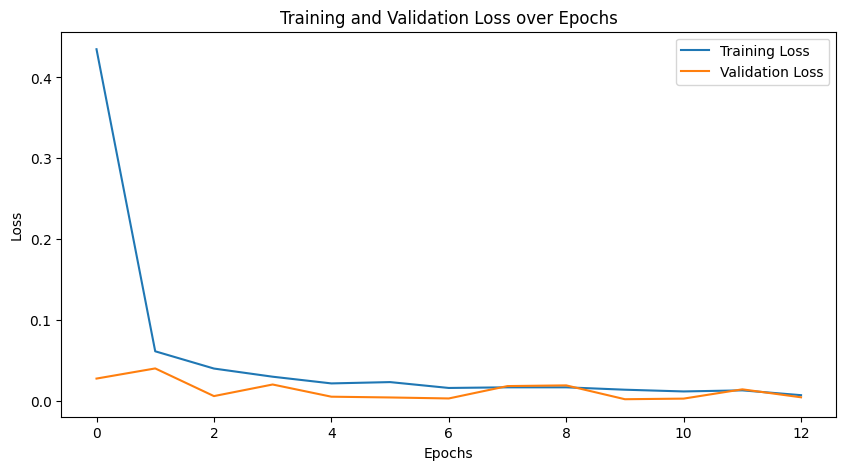

In [51]:
model = CNN(size=(32, 1, 128, 128), optimizer='Adam', activation='relu', pool_type='max', 
            task='classification', stride=2, num_conv_layers=3, conv_kernel_size=3, 
            pool_kernel_size=2, num_classes=4, dropout_rate=0.5)
model.train_model(train_loader=train, val_loader=val, num_epochs=30, learning_rate=0.001, patience=3)

#### Visualising feature maps for 3 random images

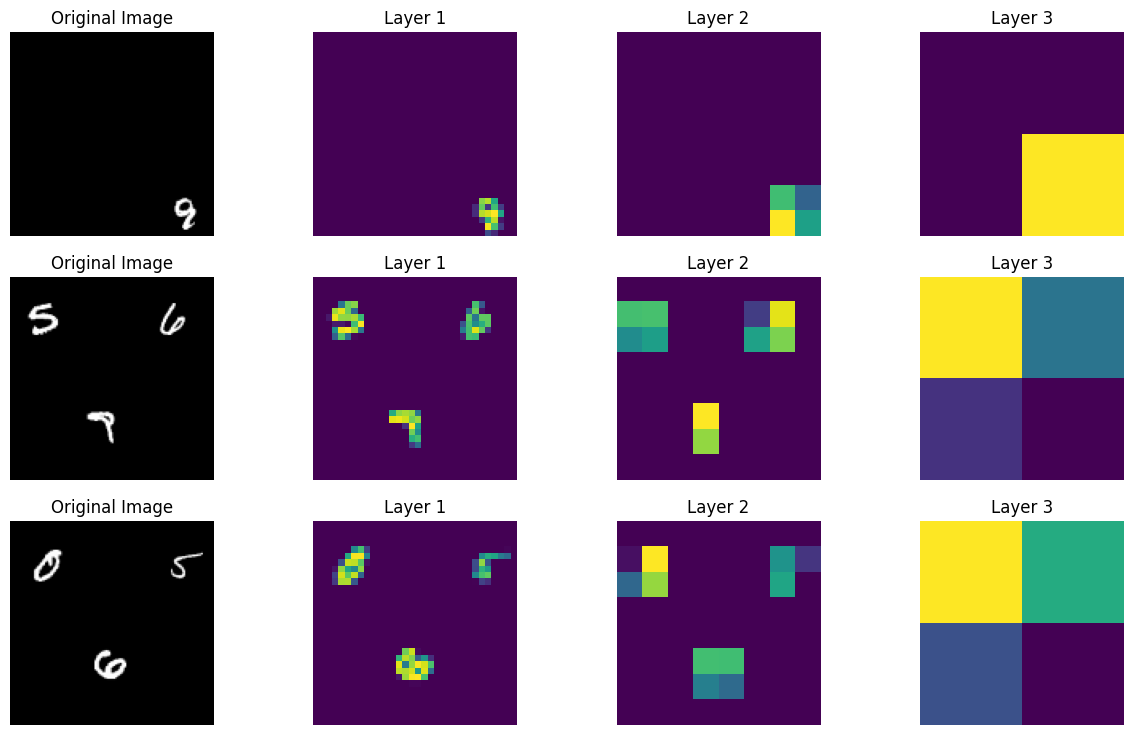

In [55]:
indices = random.sample(range(len(test_df)), 3)
sample_images = [test_df[idx][0] for idx in indices]
sample_images = torch.stack(sample_images)
model.visualize_feature_maps(sample_images, num_images=3)

### Observation:
#### Layer 1:

* The feature maps in the first layer highlight edges and simple shapes of the digits, as expected.

#### Layer 2:

* The feature maps from this layer show slightly more abstract patterns, capturing combinations of edges and forming more coherent parts of the digit shapes.

#### Layer 3:

* The final layer’s feature maps have low spatial resolution but show large regions of activation.

## Inference:

* The feature maps from the first few layers capture basic patterns such as edges, textures, and simple shapes in the input image.
* Feature maps from intermediate layers start to detect more complex structures, such as parts of objects, textures, and patterns that are combinations of the lower-level features.
* Feature maps from the deepest layers are more abstract and tend to represent high-level concepts or class-specific features.